<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_Customer_Churn/Customer_Churn_Raw_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Kaggle Playground Series - Season 4, Episode 3: Customer Churn Prediction

## Overview

*   **Competition Type:** Binary Classification (Tabular Data)
*   **Goal:** Predict the likelihood of customer churn.
*   **Evaluation Metric:** Area Under the ROC Curve (**AUC-ROC**).

---

## Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on a customer churn prediction dataset. Feature distributions are close to, but not exactly the same, as the original. You can use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

### Files

*   `train.csv`: The training set, where `Churn` is the target variable.
*   `test.csv`: The test set for which you need to predict churn probabilities.
*   `sample_submission.csv`: A sample submission file in the correct format.

### Key Features (from `df_train` exploration)

| Feature | Description |
| :--- | :--- |
| **gender** | Customer's gender (Male/Female). |
| **SeniorCitizen** | Indicates if the customer is a senior citizen (1) or not (0). |
| **Partner** | Indicates if the customer has a partner (Yes/No). |
| **Dependents** | Indicates if the customer has dependents (Yes/No). |
| **tenure** | Number of months the customer has stayed with the company. |
| **PhoneService** | Indicates if the customer has phone service (Yes/No). |
| **MultipleLines** | Indicates if the customer has multiple lines (Yes/No/No phone service). |
| **InternetService** | Type of internet service (DSL/Fiber optic/No). |
| **OnlineSecurity** | Indicates if the customer has online security (Yes/No/No internet service). |
| **OnlineBackup** | Indicates if the customer has online backup (Yes/No/No internet service). |
| **DeviceProtection** | Indicates if the customer has device protection (Yes/No/No internet service). |
| **TechSupport** | Indicates if the customer has tech support (Yes/No/No internet service). |
| **StreamingTV** | Indicates if the customer has streaming TV (Yes/No/No internet service). |
| **StreamingMovies** | Indicates if the customer has streaming movies (Yes/No/No internet service). |
| **Contract** | The type of contract the customer has (Month-to-month/One year/Two year). |
| **PaperlessBilling** | Indicates if the customer has paperless billing (Yes/No). |
| **PaymentMethod** | The customer's payment method (e.g., Electronic check, Mailed check). |
| **MonthlyCharges** | The amount charged to the customer monthly. |
| **TotalCharges** | The total amount charged to the customer. |
| **Churn** | **TARGET VARIABLE**: Indicates if the customer churned (Yes/No). |

---

In [2]:
import os
import time
import warnings
import random
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

!pip install optuna-integration[lightgbm]
!pip install optuna
import optuna
from tqdm.notebook import tqdm
import lightgbm as lgb
import xgboost as xgb
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback
from sklearn.linear_model import LogisticRegression

import sklearn
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, LabelEncoder, RobustScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

!pip install catboost
!pip uninstall -y pytabkit pytorch-lightning torchmetrics torchvision
!pip install torch==2.3.1
!pip install torchvision
!pip install pytabkit

from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from pytabkit import RealMLP_TD_Classifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from typing import List, Tuple, Dict, Any
print("Required libraries installed and imported.")

import subprocess

packages_to_install = [
    'scikit-learn==1.6.1',
    'tqdm==4.67.3',
    'optuna==4.7.0'
]

for pkg in packages_to_install:
    try:
        print(f"Installing {pkg}...")
        result = subprocess.run(['pip', 'install', pkg], capture_output=True, text=True, check=True)
        print(result.stdout)
        if result.stderr:
            print(result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"Error installing {pkg}: {e.stderr}")
    except FileNotFoundError:
        print("Error: pip command not found. Please ensure pip is installed.")

print("All required libraries installed.")

Found existing installation: pytabkit 1.7.3
Uninstalling pytabkit-1.7.3:
  Successfully uninstalled pytabkit-1.7.3
Found existing installation: pytorch-lightning 2.6.1
Uninstalling pytorch-lightning-2.6.1:
  Successfully uninstalled pytorch-lightning-2.6.1
Found existing installation: torchmetrics 1.8.2
Uninstalling torchmetrics-1.8.2:
  Successfully uninstalled torchmetrics-1.8.2
Found existing installation: torchvision 0.25.0
Uninstalling torchvision-0.25.0:
  Successfully uninstalled torchvision-0.25.0
  Using cached torch-2.3.1-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_c

# 1. Setup & Data Loading

In [3]:
import pandas as pd
import numpy as np
# --- Global Configuration Parameters ---
SEED = 42
SEEDS = [SEED]
FOLDS = 5
TARGET = 'Churn'

ACTIVE_MODEL = 'Ensemble'

import pandas as pd
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- 1. Load datasets ---
print("Loading datasets...")
TRAIN_PATH = '/content/drive/MyDrive/Kaggle/playground_Churn/train.csv'
TEST_PATH = '/content/drive/MyDrive/Kaggle/playground_Churn/test.csv'
# orig_path = '/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv'
SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/Kaggle/playground_Churn/sample_submission.csv'

# Load dataframes globally so they are accessible
try:
    df_train = pd.read_csv(TRAIN_PATH)
    df_test = pd.read_csv(TEST_PATH)
    df_sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: One or more dataset files not found. Please check paths: {e}")
    print("Ensure the CSV files are correctly placed in your Google Drive at: /content/drive/MyDrive/Kaggle/playground_Churn/")
    # Optionally, set empty dataframes or exit
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    df_sample_submission = pd.DataFrame()
except Exception as e:
    print(f"An unexpected error occurred during dataset loading: {e}")
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    df_sample_submission = pd.DataFrame()

# --- Define Target and Feature Lists for Churn Competition ---
# TARGET is already defined in the setup cell (1mhl0PT1BV5e)
CHURN_MAP = {'Yes': 1, 'No': 0}

NUM_COLUMNS = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
CAT_COLUMNS = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

ADD_EXTERN_DATA = False
USE_EXTERNAL_FEATS = False

# --- Model-specific Hyperparameters ---

CATBOOST_PARAMS = {
    'iterations': 1,
    'learning_rate': 0.02,
    'depth': 2,
    'min_data_in_leaf': 1,
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'bootstrap_type': 'Bernoulli',
    'early_stopping_rounds': 300,
    'verbose': False,
    'subsample': 0.9,
    'random_seed': SEED
}



REALMLP_TD_PARAMS = {
    'device': 'cpu',   #cuda
    'random_state': SEED,
    'verbosity': 2,
    'n_epochs': 1,
    'batch_size': 256,
    'n_ens': 8,
    'use_early_stopping': True,
    'early_stopping_additive_patience': 20,
    'early_stopping_multiplicative_patience': 1,
    'act': "mish",
    'embedding_size': 8,
    'first_layer_lr_factor': 0.5962121993798933,
    'hidden_sizes': "rectangular",
    'hidden_width': 384,
    'lr': 0.04,
    'ls_eps': 0.011498317194338772,
    'ls_eps_sched': "coslog4",
    'max_one_hot_cat_size': 18,
    'n_hidden_layers': 4,
    'p_drop': 0.07301419697186451,
    'p_drop_sched': "flat_cos",
    'plr_hidden_1': 16,
    'plr_hidden_2': 8,
    'plr_lr_factor': 0.1151437622270563,
    'plr_sigma': 2.3316811282666916,
    'scale_lr_factor': 2.244801835541429,
    'sq_mom': 1.0 - 0.011834054955582318,
    'wd': 0.02369230879235962,
}

def set_seed(seed_value=SEED):
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if 'torch' in globals():
        import torch
        torch.manual_seed(seed_value)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed_value)
            torch.cuda.manual_seed_all(seed_value)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

set_seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...
Datasets loaded successfully.


In [4]:
print("Configuration loaded.")

# Dataframes are now loaded in cell pAZ19r1hDngN
# print("Datasets loaded successfully.")

# --- 2. Print the shape of each dataset ---
print("\n--- Dataset Shapes ---")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
# print(f"Shape of df_orig: {df_orig.shape}")
print(f"Shape of df_sample_submission: {df_sample_submission.shape}")

def load_and_prepare_initial_data(
    train_csv_path: str,
    test_csv_path: str,
    target_column: str,
    target_map: Dict[str, int]
) -> Tuple[pd.DataFrame, pd.Series, np.ndarray, pd.DataFrame]:

    print("Preparing initial data (using specified paths and target mapping)...")

    # Load dataframes - these are local to this function if called independently
    df_train_raw = pd.read_csv(train_csv_path)
    df_test_raw = pd.read_csv(test_csv_path)

    df_train_local = df_train_raw.copy()

    print(f"Encoding '{target_column}' target variable...")
    # Encode target variable
    if target_column in df_train_local.columns:
        if df_train_local[target_column].dtype == 'object':
            df_train_local[target_column] = df_train_local[target_column].map(target_map).astype(np.uint8)
        else:
            if not pd.api.types.is_unsigned_integer_dtype(df_train_local[target_column]):
                df_train_local[target_column] = df_train_local[target_column].astype(np.uint8)
    else:
        raise ValueError(f"'{target_column}' column not found in training data.")

    # Separate features and target
    X = df_train_local.drop(['id', target_column], axis=1)
    y = df_train_local[target_column]
    test_ids = df_test_raw['id'].values
    X_test = df_test_raw.drop(['id'], axis=1)

    print(f"Initial data prepared. X shape: {X.shape}, y shape: {y.shape}, X_test shape: {X_test.shape}")
    return X, y, test_ids, X_test

print("data_loader functions defined.")

Configuration loaded.

--- Dataset Shapes ---
Shape of df_train: (594194, 21)
Shape of df_test: (254655, 20)
Shape of df_sample_submission: (254655, 2)
data_loader functions defined.


In [5]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")


📊 Comprehensive Information for DataFrame: df_train

Shape: 594194 rows × 21 columns

--- df_train Head ---



,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Male,0,Yes,Yes,29,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,Yes,Mailed check,60.100000,1653.850000,No
1,1,Male,0,Yes,Yes,58,Yes,No,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic),69.500000,3778.200000,No
2,2,Male,0,Yes,No,58,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.400000,5841.350000,No
3,3,Female,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.700000,70.700000,Yes
4,4,Female,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.450000,70.450000,Yes



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,594194,594194,0,0.000000
gender,object,594194,2,0,0.000000
SeniorCitizen,int64,594194,2,0,0.000000
Partner,object,594194,2,0,0.000000
Dependents,object,594194,2,0,0.000000
tenure,int64,594194,72,0,0.000000
PhoneService,object,594194,2,0,0.000000
MultipleLines,object,594194,3,0,0.000000
InternetService,object,594194,3,0,0.000000
OnlineSecurity,object,594194,3,0,0.000000



--- df_train Numeric Summary ---



,id,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,594194.000000,594194.000000,594194.000000,594194.000000,594194.000000
mean,297096.500000,0.114102,36.577258,65.866223,2494.377057
std,171529.177262,0.317936,25.061922,31.067444,2353.916710
min,0.000000,0.000000,1.000000,18.250000,18.800000
25%,148548.250000,0.000000,12.000000,29.900000,639.650000
50%,297096.500000,0.000000,35.000000,74.100000,1433.650000
75%,445644.750000,0.000000,62.000000,90.800000,4263.800000
max,594193.000000,1.000000,72.000000,118.750000,8684.800000



--- df_train Categorical Summary ---



,count,unique,top,freq
gender,594194,2,Female,298738
Partner,594194,2,Yes,309554
Dependents,594194,2,No,414362
PhoneService,594194,2,Yes,557893
MultipleLines,594194,3,No,283384
InternetService,594194,3,Fiber optic,272386
OnlineSecurity,594194,3,No,289474
OnlineBackup,594194,3,No,250083
DeviceProtection,594194,3,No,247377
TechSupport,594194,3,No,288571





📊 Comprehensive Information for DataFrame: df_test

Shape: 254655 rows × 20 columns

--- df_test Head ---



,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,594194,Female,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,115.550000,8061.500000
1,594195,Female,0,Yes,No,71,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.800000,1336.500000
2,594196,Male,0,No,No,12,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),55.550000,633.550000
3,594197,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),84.100000,6457.150000
4,594198,Female,0,No,No,15,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,90.350000,1233.650000



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,254655,254655,0,0.000000
gender,object,254655,2,0,0.000000
SeniorCitizen,int64,254655,2,0,0.000000
Partner,object,254655,2,0,0.000000
Dependents,object,254655,2,0,0.000000
tenure,int64,254655,72,0,0.000000
PhoneService,object,254655,2,0,0.000000
MultipleLines,object,254655,3,0,0.000000
InternetService,object,254655,3,0,0.000000
OnlineSecurity,object,254655,3,0,0.000000



--- df_test Numeric Summary ---



,id,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,254655.000000,254655.000000,254655.000000,254655.000000,254655.000000
mean,721521.000000,0.113620,37.279716,66.130803,2544.617351
std,73512.710738,0.317350,24.777625,31.104139,2348.124379
min,594194.000000,0.000000,1.000000,18.300000,18.800000
25%,657857.500000,0.000000,13.000000,30.150000,677.625000
50%,721521.000000,0.000000,36.000000,74.350000,1468.750000
75%,785184.500000,0.000000,62.000000,91.100000,4317.300000
max,848848.000000,1.000000,72.000000,118.750000,8684.800000



--- df_test Categorical Summary ---



,count,unique,top,freq
gender,254655,2,Female,127935
Partner,254655,2,Yes,134703
Dependents,254655,2,No,177016
PhoneService,254655,2,Yes,239173
MultipleLines,254655,3,No,120252
InternetService,254655,3,Fiber optic,116731
OnlineSecurity,254655,3,No,122693
OnlineBackup,254655,3,No,105402
DeviceProtection,254655,3,No,104724
TechSupport,254655,3,No,122146


In [6]:
excluded_features = ['id', 'Churn']

print("\n--- Feature Classification Based on df_train ---")


numerical_features = [
    col for col in df_train.select_dtypes(include=np.number).columns
    if col not in excluded_features
]


categorical_features = [
    col for col in df_train.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]


print("Numerical Features:")
print(f"  Total Count: {len(numerical_features)}")
print(f"  List: {numerical_features}\n")

print("Categorical Features:")
print(f"  Total Count: {len(categorical_features)}")
print(f"  List: {categorical_features}\n")

print("Excluded Features (ID and Target Variable):")
print(f"  List: {excluded_features}\n")


--- Feature Classification Based on df_train ---
Numerical Features:
  Total Count: 4
  List: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical Features:
  Total Count: 15
  List: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Excluded Features (ID and Target Variable):
  List: ['id', 'Churn']



In [7]:
print("\n--- Numerical Features in df_train ---")
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'id' and 'TARGET' from numerical analysis if they are present and not truly numerical features
if 'id' in num_cols:
    num_cols = num_cols.drop('id')
if TARGET in num_cols:
    num_cols = num_cols.drop(TARGET)


if len(num_cols) > 0:
    print(df_train[num_cols].describe())
else:
    print("No numerical columns (excluding 'id' and 'TARGET') found in df_train.")


--- Numerical Features in df_train ---
       SeniorCitizen         tenure  MonthlyCharges   TotalCharges
count  594194.000000  594194.000000   594194.000000  594194.000000
mean        0.114102      36.577258       65.866223    2494.377057
std         0.317936      25.061922       31.067444    2353.916710
min         0.000000       1.000000       18.250000      18.800000
25%         0.000000      12.000000       29.900000     639.650000
50%         0.000000      35.000000       74.100000    1433.650000
75%         0.000000      62.000000       90.800000    4263.800000
max         1.000000      72.000000      118.750000    8684.800000


/tmp/ipython-input-10867/3487546576.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


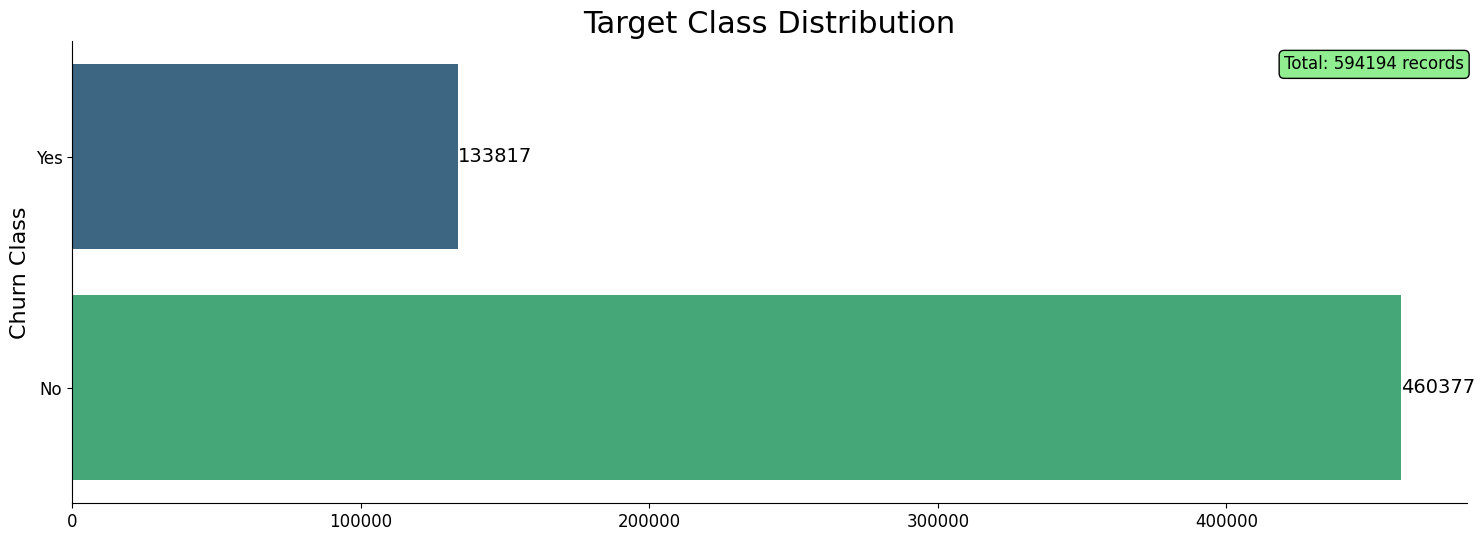

In [8]:
fig = plt.figure(figsize=(18, 6))
plt.title('Target Class Distribution', fontsize=22);

status_distribution = df_train[TARGET].value_counts().sort_values()

bar_plot = sns.barplot(
    x=status_distribution.values,
    y=status_distribution.index.astype(str),
    palette="viridis",
    orient="h"
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel('Churn Class', fontsize=16);

text_params = {
    'x'       : status_distribution.max() * 0.98,
    'y'       : -0.4,
    's'       : f"Total: {len(df_train)} records",
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center",
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);
plt.grid(False);
sns.despine();


--- Visualizing Categorical Features against Churn ---


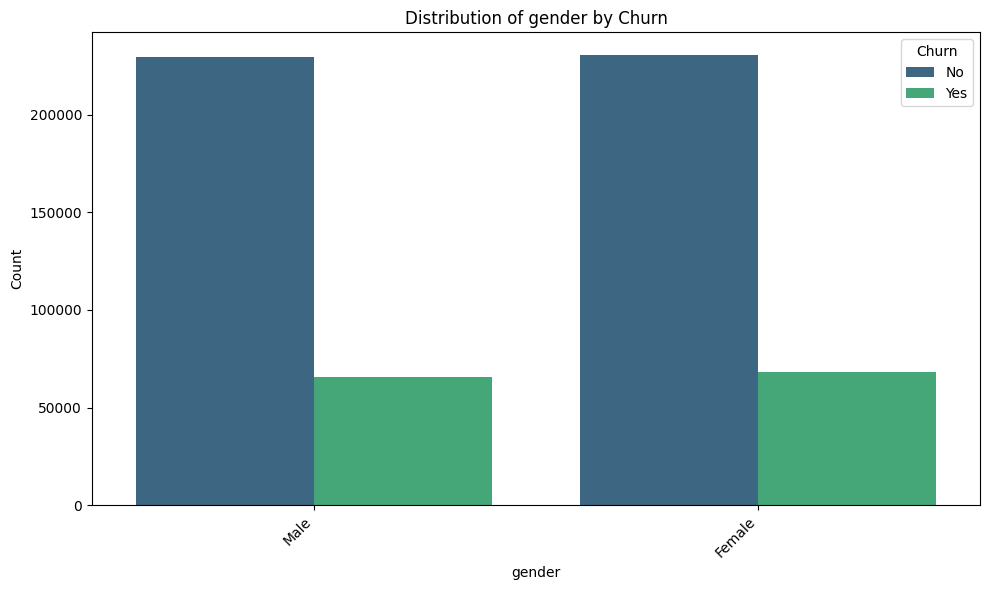

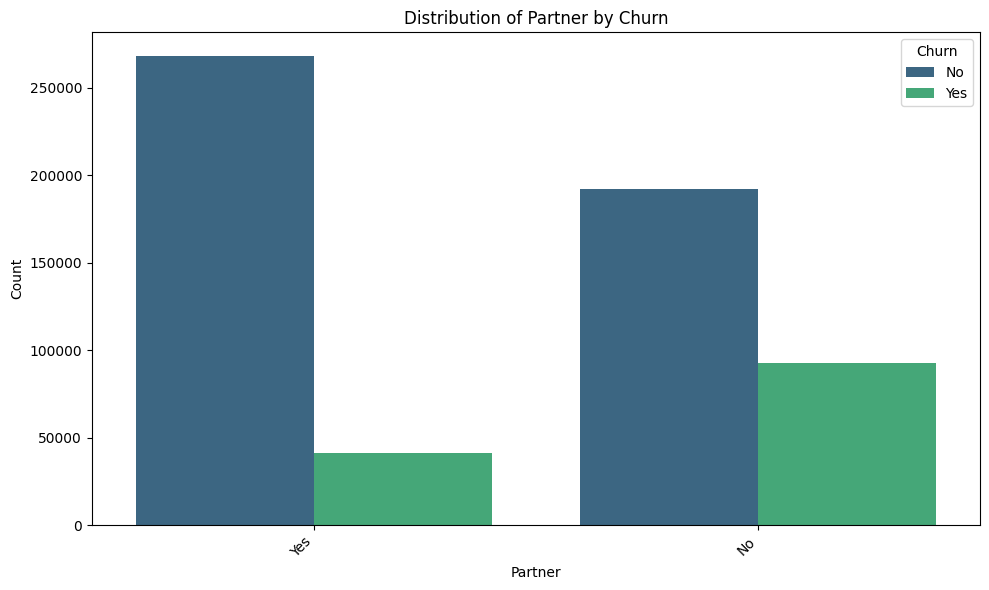

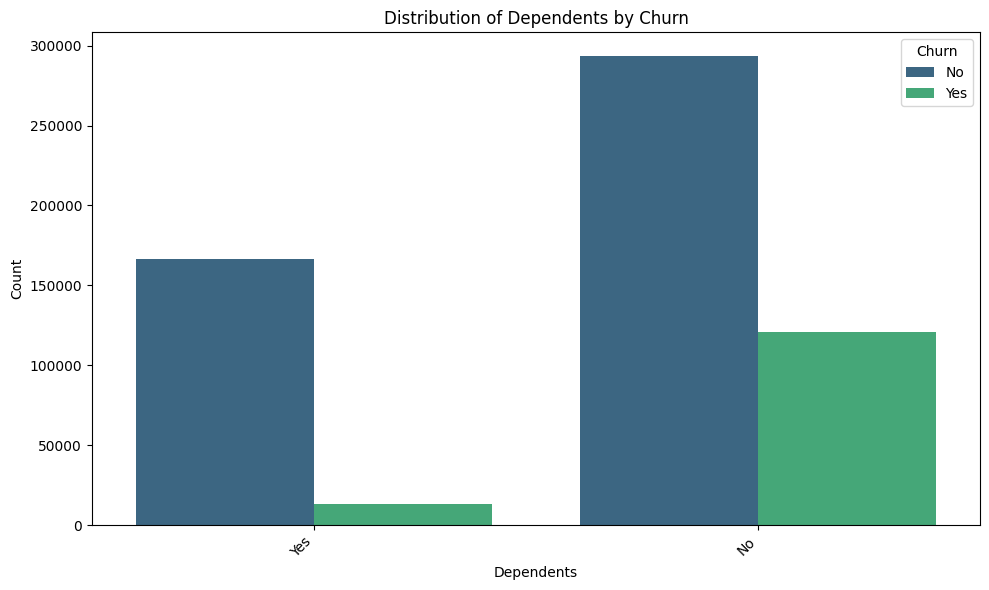

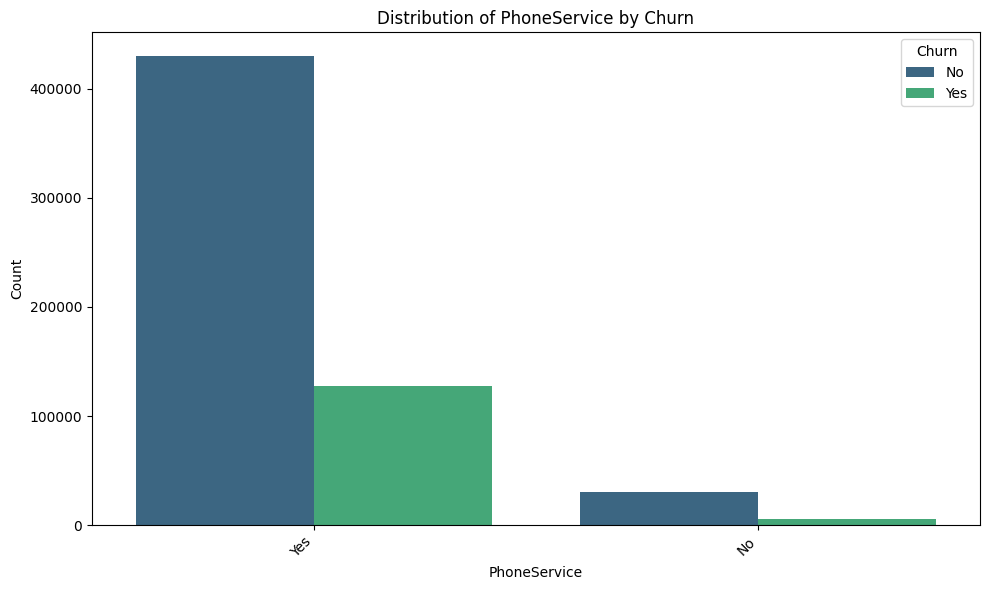

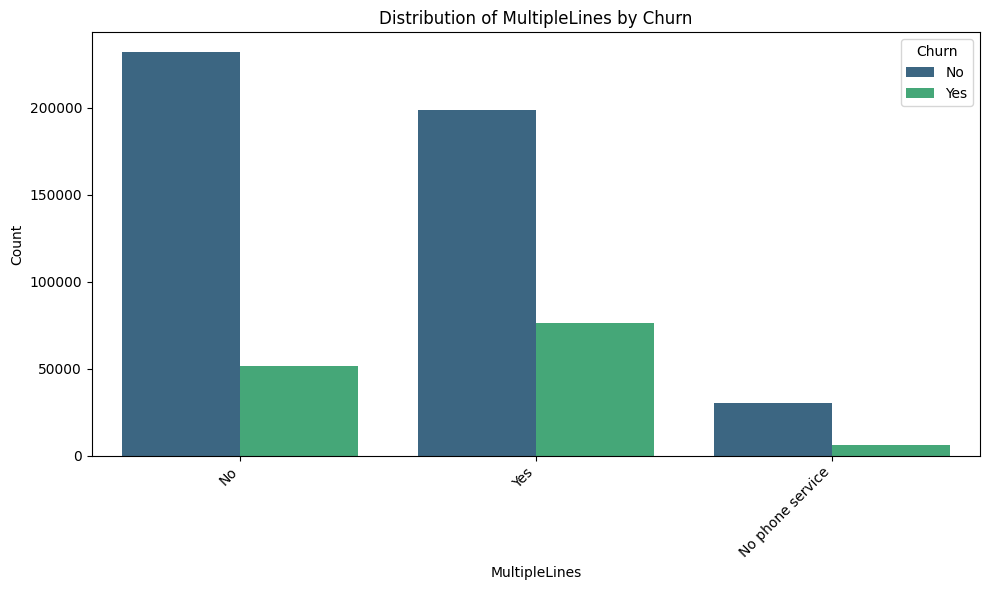

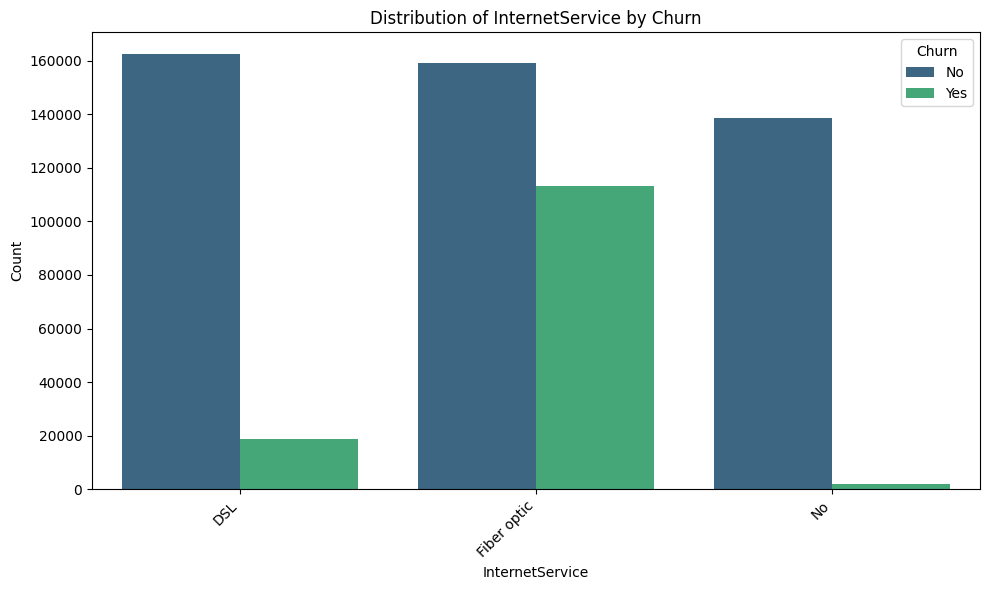

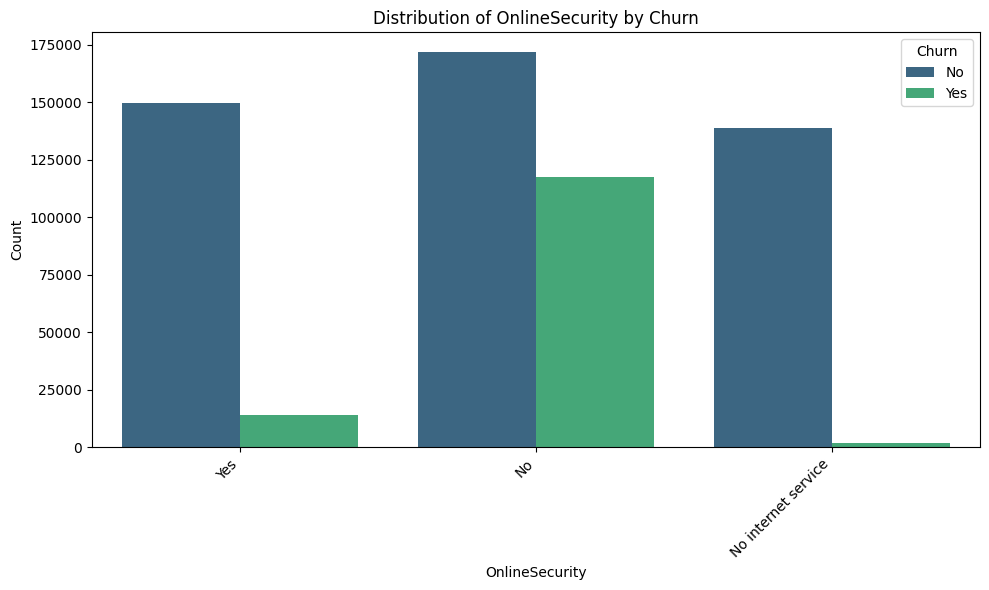

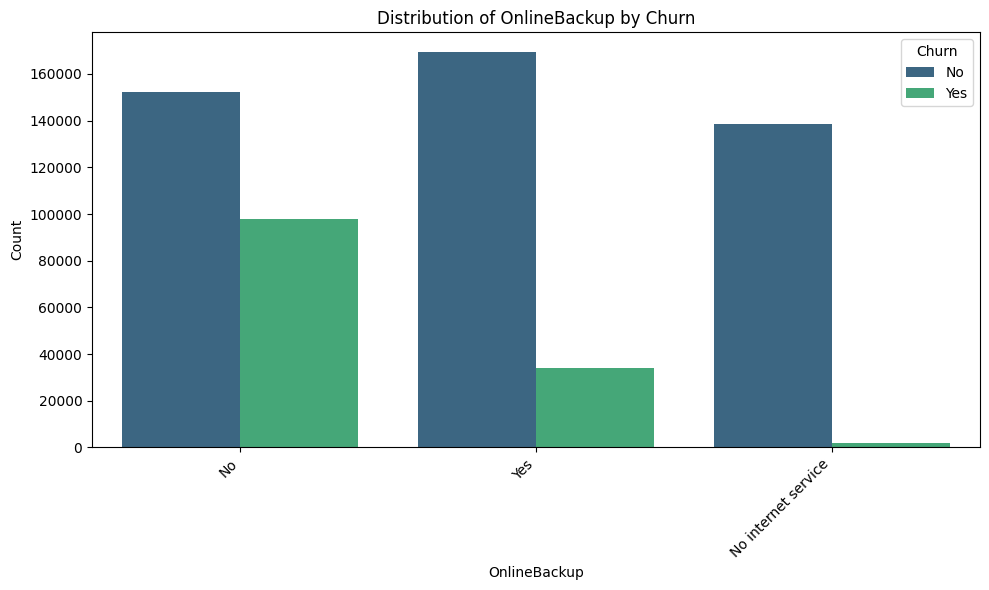

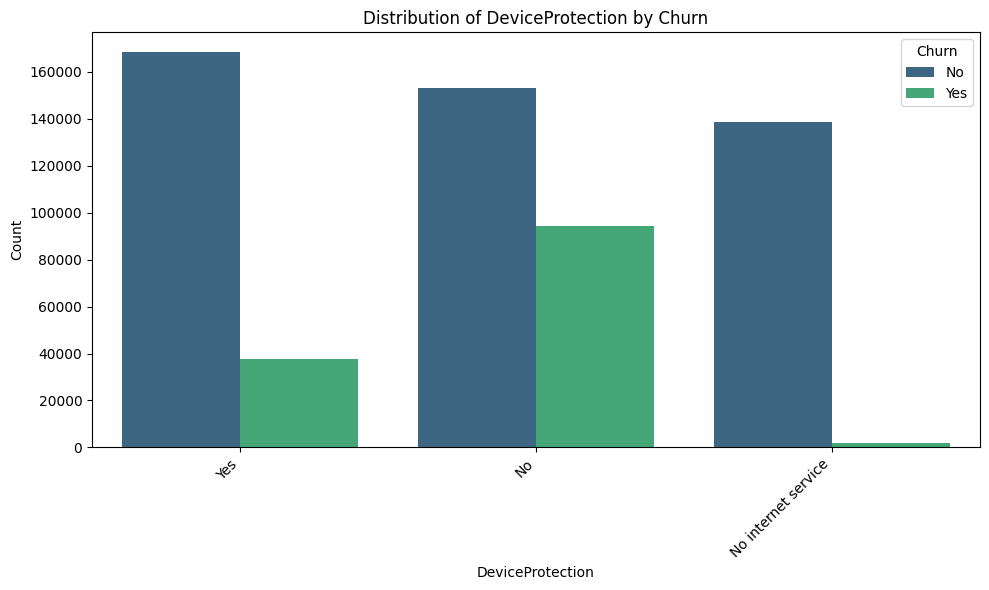

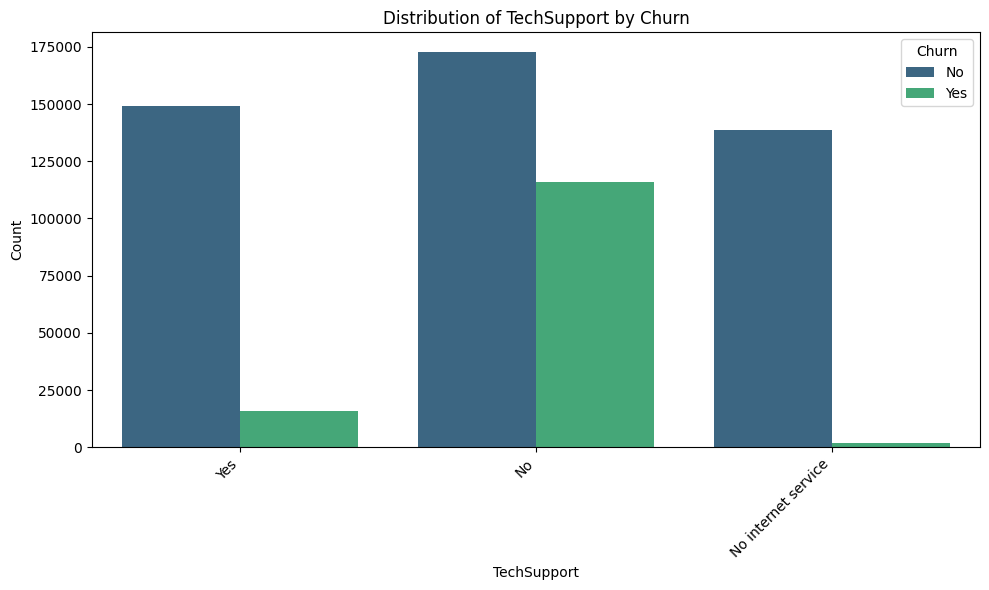

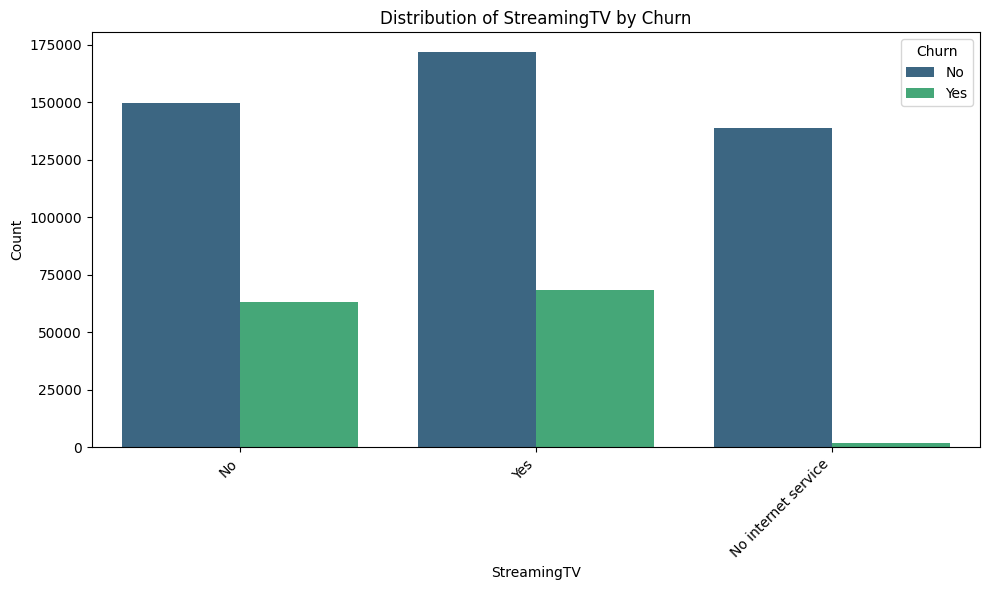

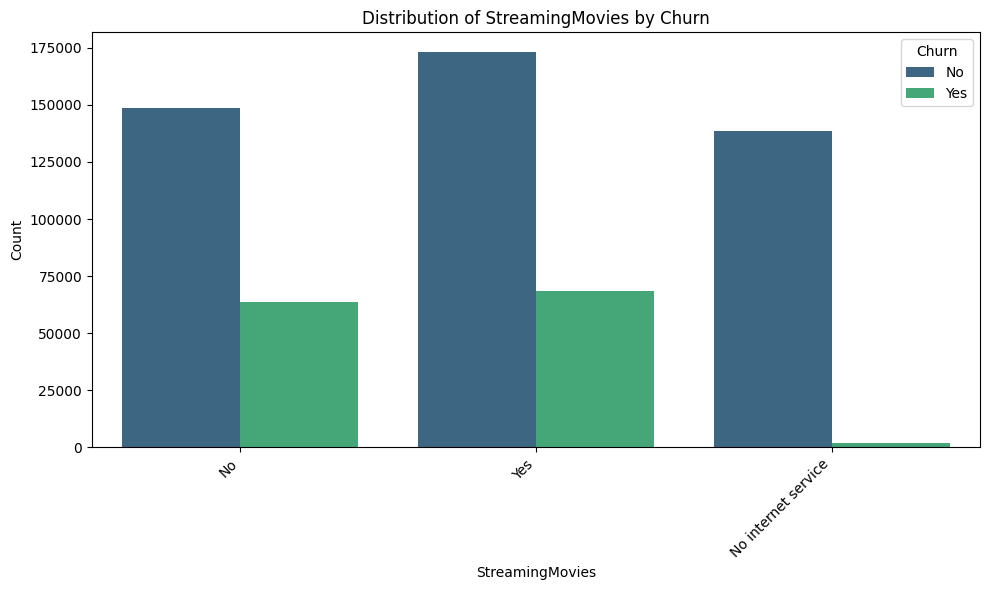

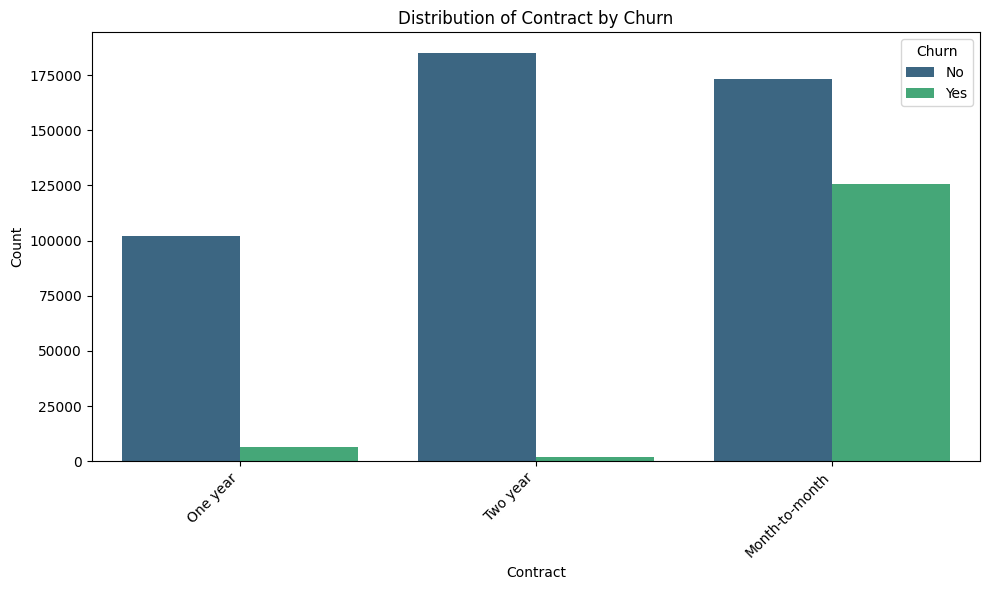

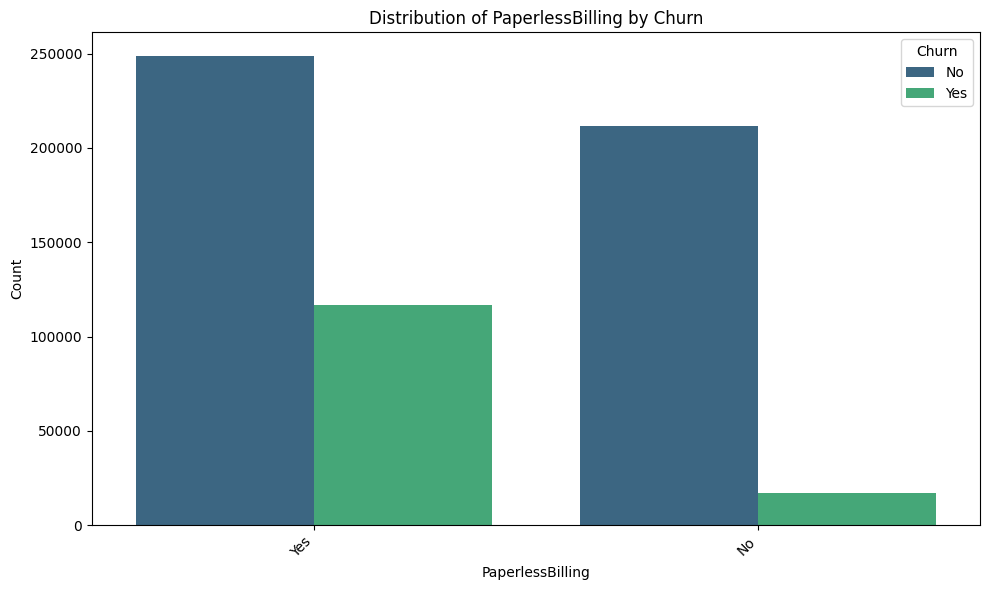

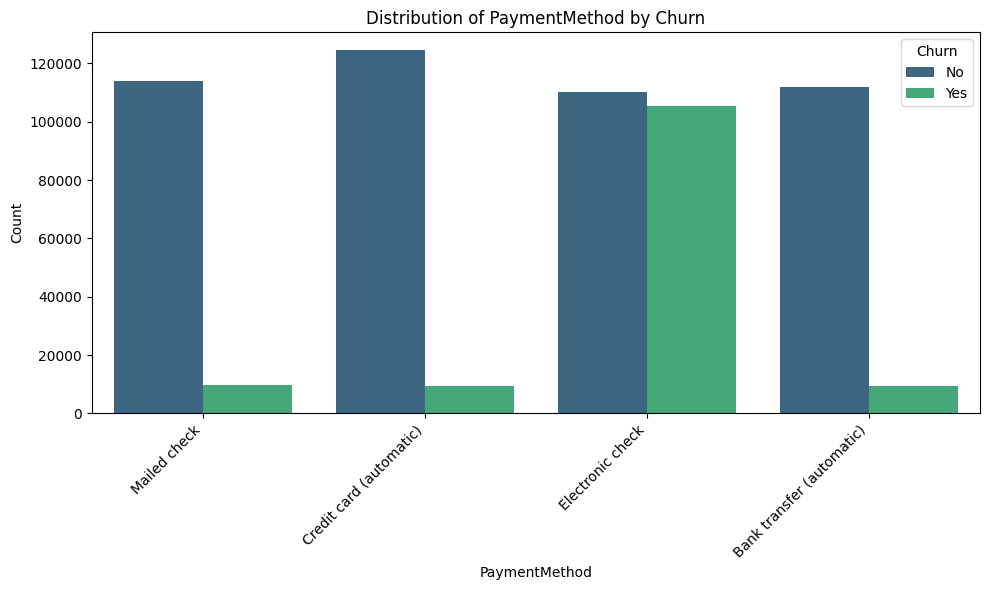

In [9]:
def plot_categorical_distribution(df, col, target):
    """Plots the distribution of a categorical column against the target variable."""
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue=target, palette='viridis')
    plt.title(f'Distribution of {col} by {target}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


print("\n--- Visualizing Categorical Features against Churn ---")
cat_cols = df_train.select_dtypes(include='object').columns

# Exclude the TARGET itself if it's in the list of categorical columns
if TARGET in cat_cols:
    cat_cols = cat_cols.drop(TARGET)

for col in cat_cols:
    plot_categorical_distribution(df_train, col, TARGET)

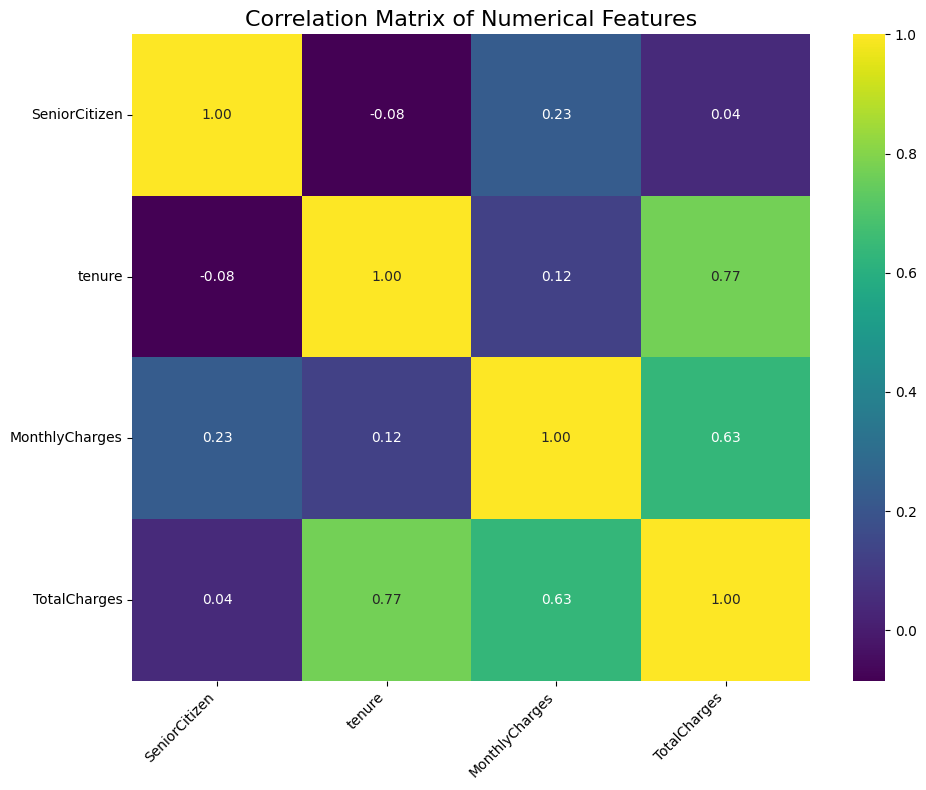

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_train[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


📌 SeniorCitizen Summary Statistics:


,Train,Test
Mean,0.114102,0.11362
Median,0.000000,0.00000
Std,0.317936,0.31735


/tmp/ipython-input-10867/2211478203.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


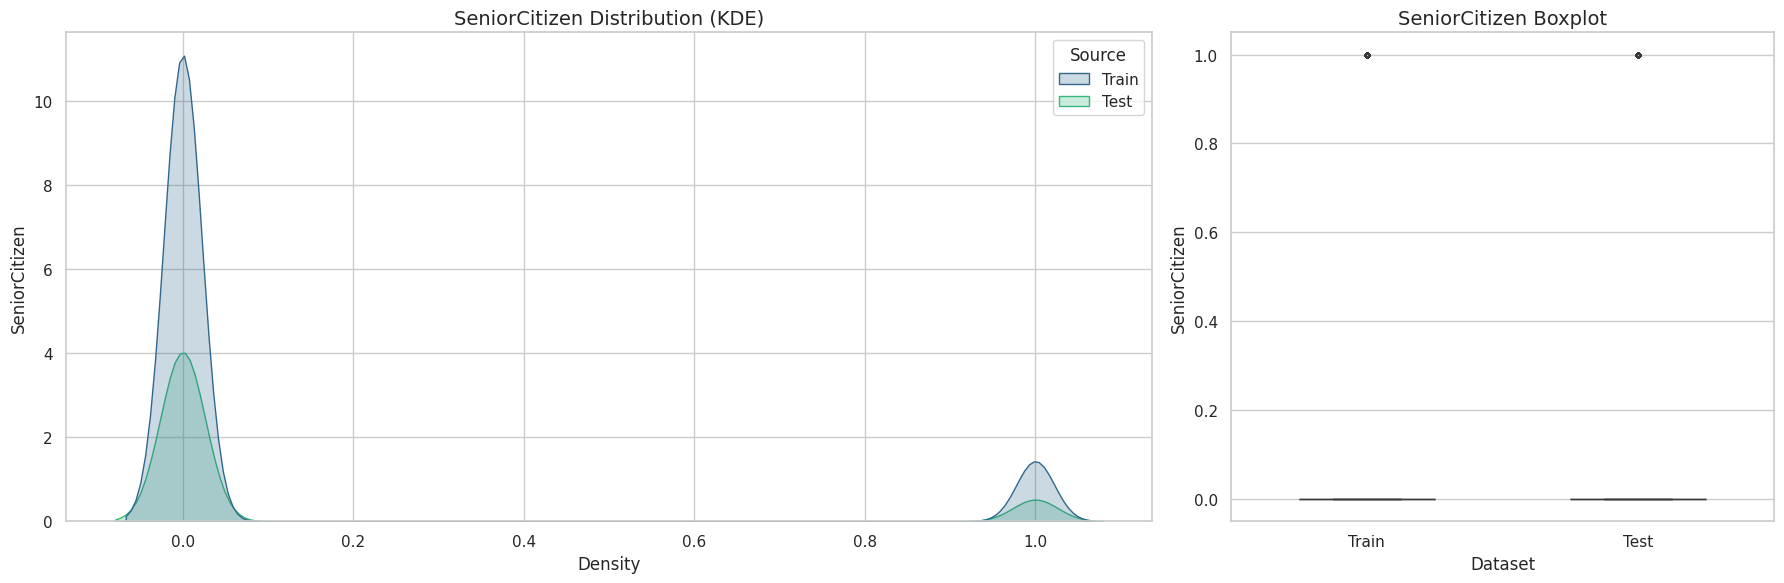


📌 tenure Summary Statistics:


,Train,Test
Mean,36.577258,37.279716
Median,35.000000,36.000000
Std,25.061922,24.777625


/tmp/ipython-input-10867/2211478203.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


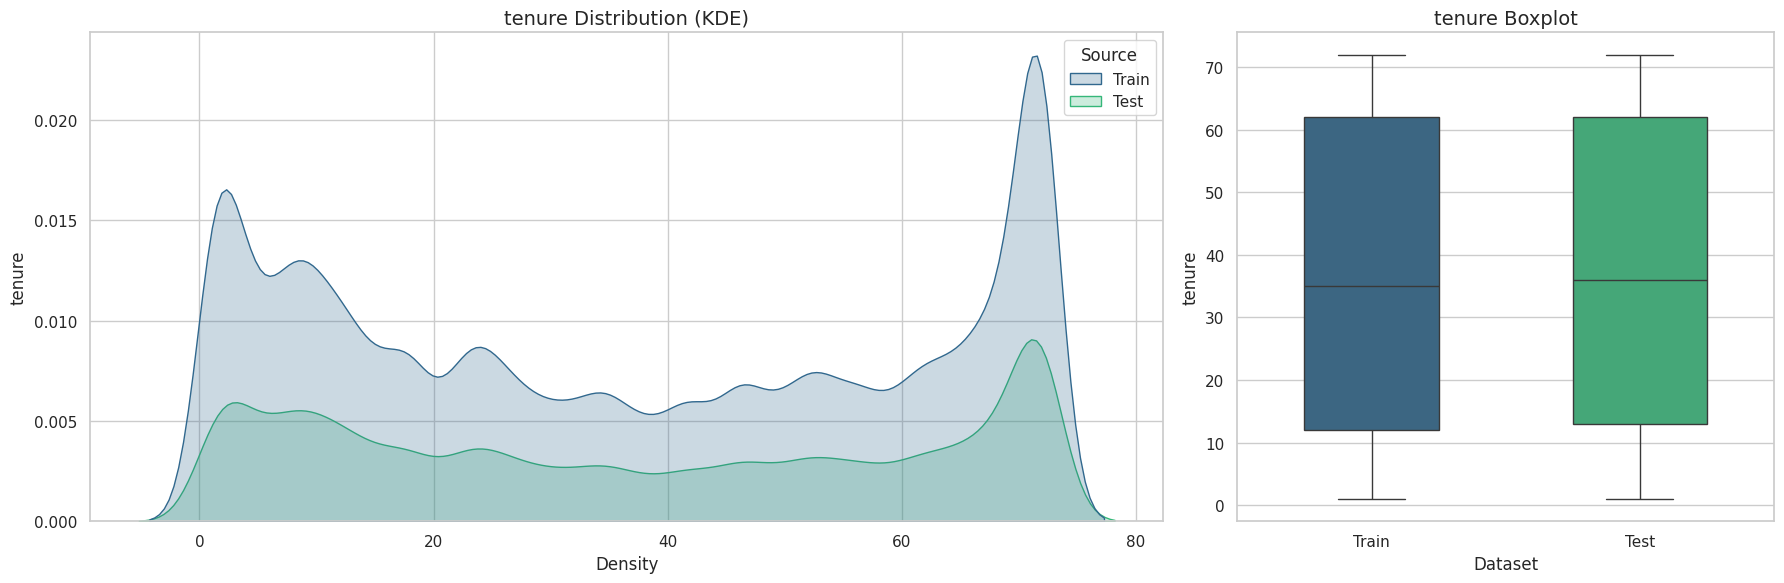


📌 MonthlyCharges Summary Statistics:


,Train,Test
Mean,65.866223,66.130803
Median,74.100000,74.350000
Std,31.067444,31.104139


/tmp/ipython-input-10867/2211478203.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


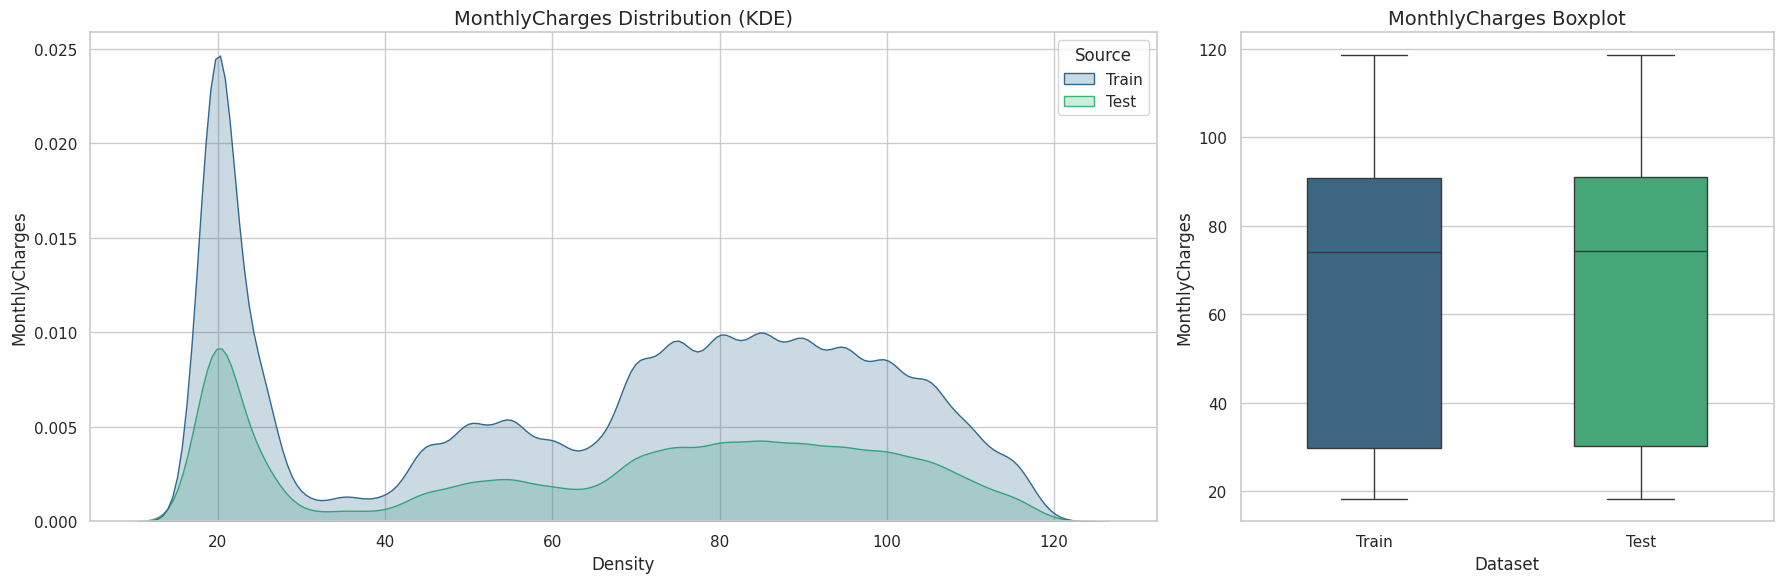


📌 TotalCharges Summary Statistics:


,Train,Test
Mean,2494.377057,2544.617351
Median,1433.650000,1468.750000
Std,2353.916710,2348.124379


/tmp/ipython-input-10867/2211478203.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


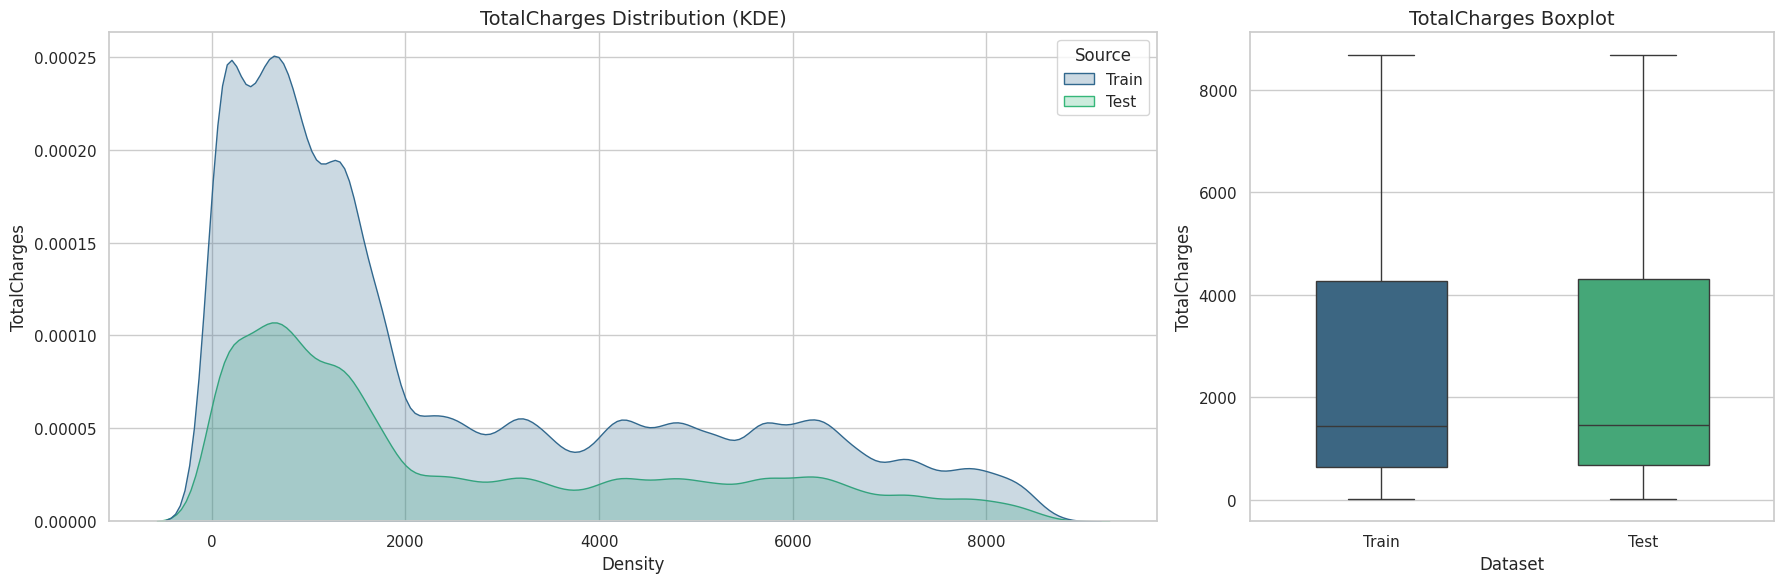

In [11]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):

    sns.set_style("whitegrid")
    sns.set_context("notebook")

    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']

    for col in numerical_cols:
        print(f"\n📌 {col} Summary Statistics:")
        display(pd.DataFrame({
            'Train': [train_df[col].mean(), train_df[col].median(), train_df[col].std()],
            'Test': [test_df[col].mean(), test_df[col].median(), test_df[col].std()]
        }, index=['Mean', 'Median', 'Std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette="viridis"
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette="viridis"
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call numerical distribution function
plot_numerical_distributions(df_train, df_test, numerical_features)

/tmp/ipython-input-10867/699709579.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/tmp/ipython-input-10867/699709579.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/tmp/ipython-input-10867/699709579.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/tmp/ipython-input-10867/699709579.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/tmp/ipython-input-10867/699709579.py:38: UserWarning: set_ticklabels() should only be u

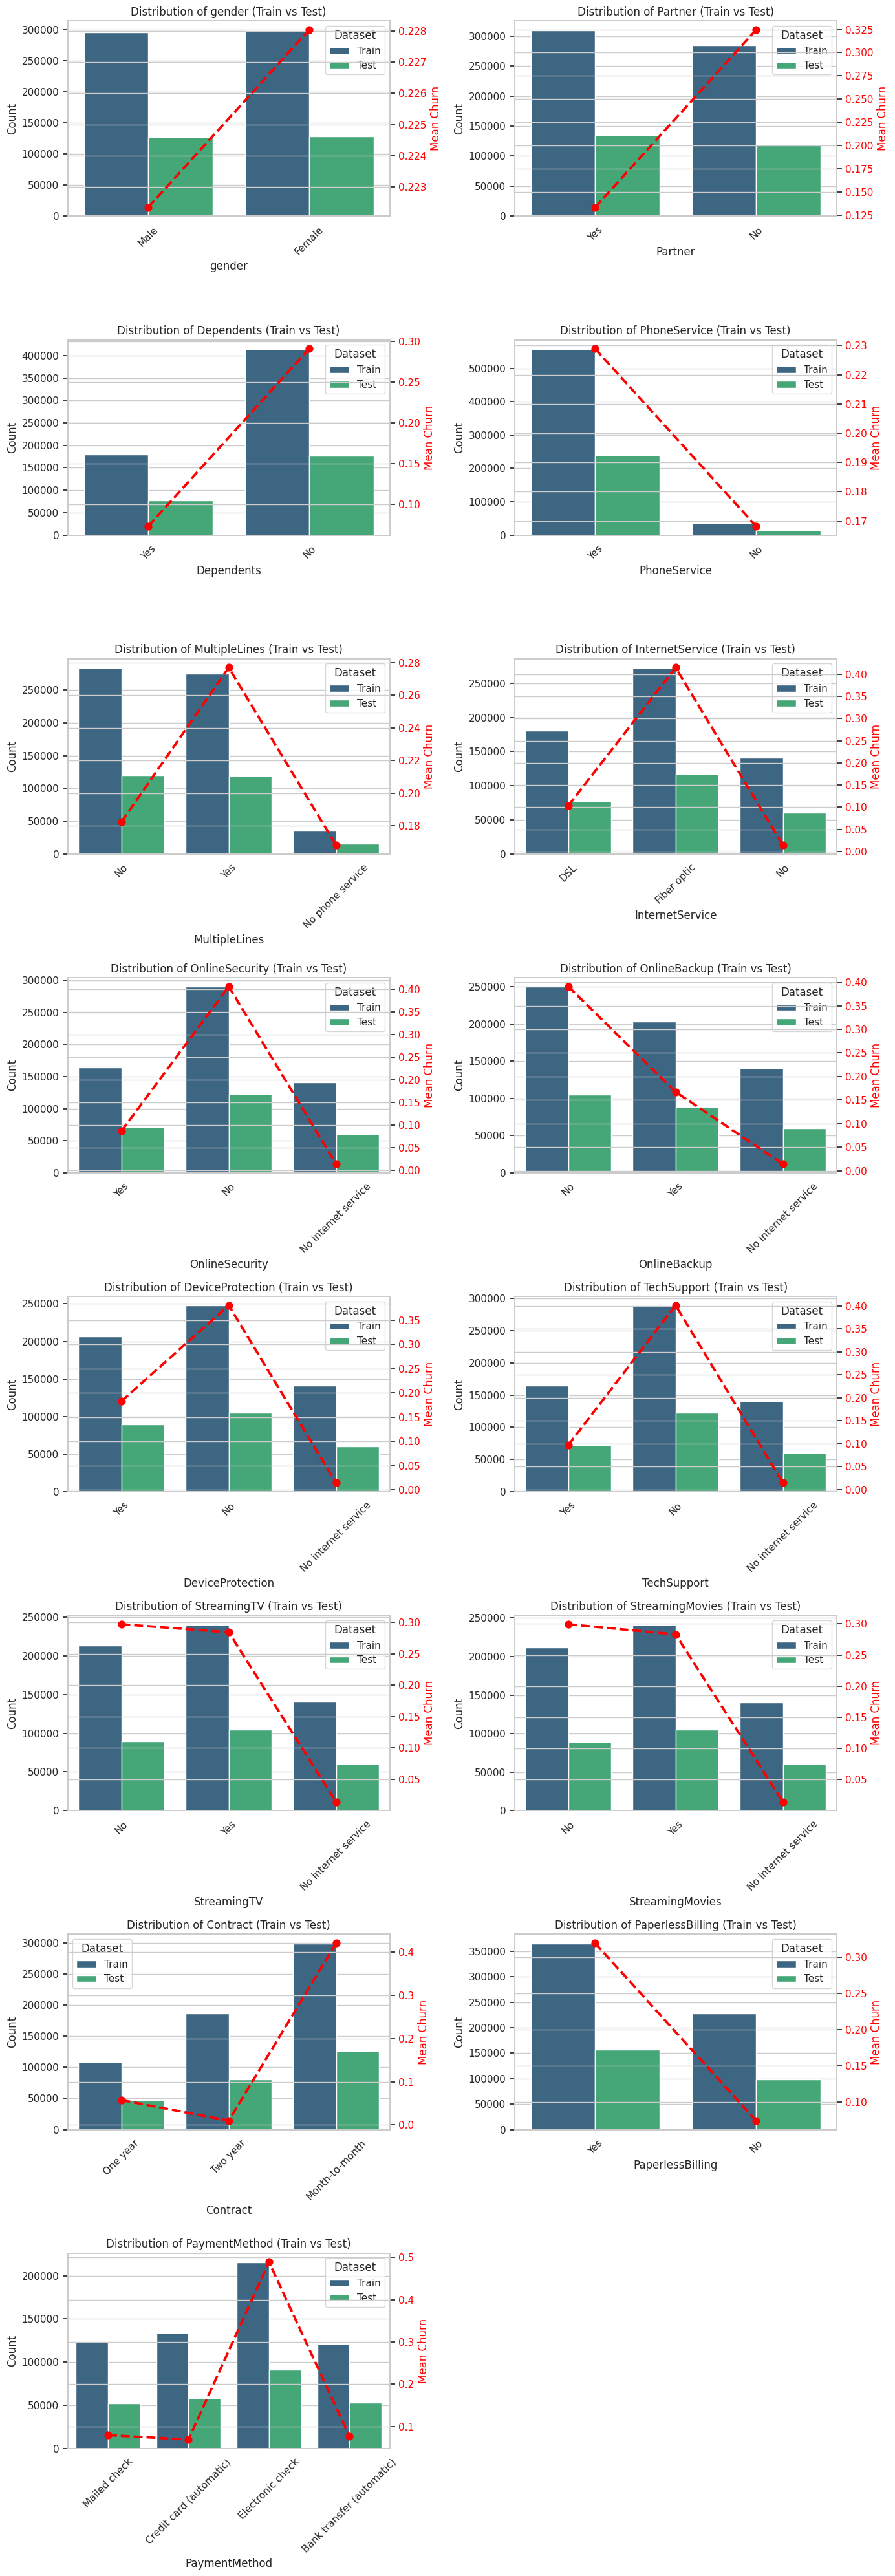

In [12]:
def plot_categorical_distributions(train_df, test_df, categorical_cols, target='Churn'):

    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten()

    # Convert target column to numeric for mean calculation
    train_df_numeric_target = train_df.copy()
    train_df_numeric_target[target] = train_df_numeric_target[target].map({'Yes': 1, 'No': 0}).astype(float)

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        combined = pd.concat(
            [train_df[[col]].assign(Source='Train'),
             test_df[[col]].assign(Source='Test')],
            axis=0, ignore_index=True
        )

        sns.countplot(x=col, hue='Source', data=combined, palette="viridis", ax=ax)
        ax.set_title(f'Distribution of {col} (Train vs Test)', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(title='Dataset')
        ax.tick_params(axis='x', rotation=45)

        target_means = train_df_numeric_target.groupby(col)[target].mean().sort_values(ascending=False)
        ax2 = ax.twinx()
        sns.pointplot(x=target_means.index, y=target_means.values, ax=ax2, color='red', markers='o', linestyles='--')
        ax2.set_ylabel(f'Mean {target}', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


features_for_comparison = [col for col in categorical_features if col != 'Churn']
plot_categorical_distributions(df_train, df_test, features_for_comparison, target='Churn')


📌 SeniorCitizen Summary Statistics by Churn:


,mean,median,std
target_numerical,,,
0.0,0.073588,0.0,0.261099
1.0,0.253488,0.0,0.435009


/tmp/ipython-input-10867/2692165875.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


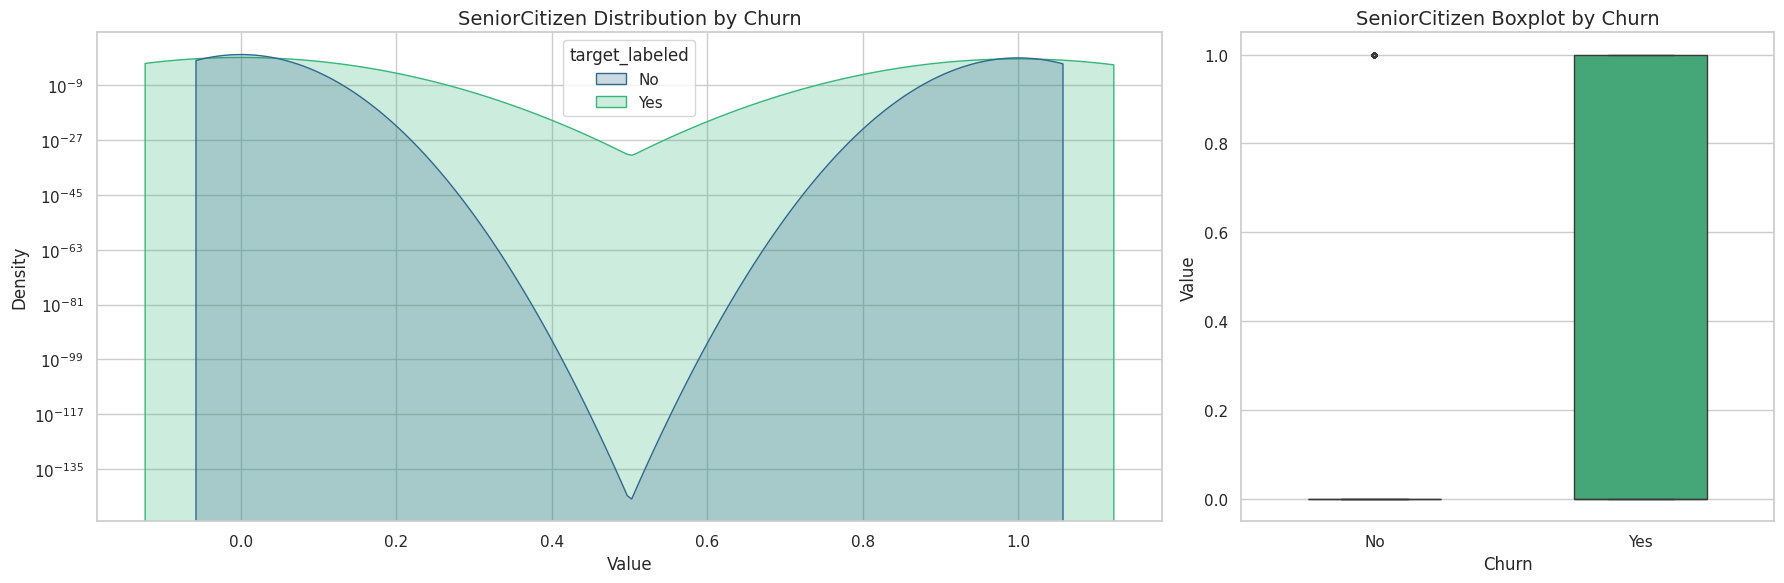


📌 tenure Summary Statistics by Churn:


,mean,median,std
target_numerical,,,
0.0,42.231313,46.0,23.987158
1.0,17.125343,10.0,17.919396


/tmp/ipython-input-10867/2692165875.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


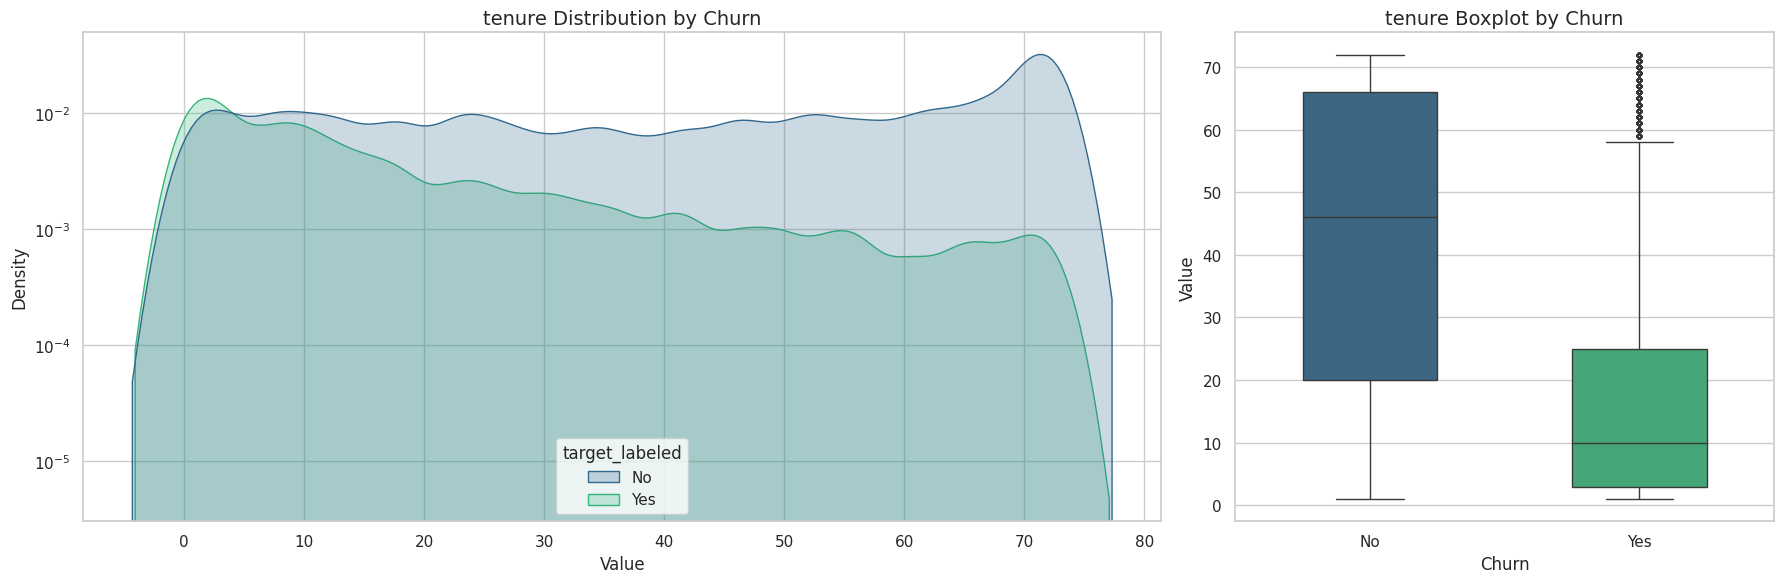


📌 MonthlyCharges Summary Statistics by Churn:


,mean,median,std
target_numerical,,,
0.0,61.293633,65.40,32.287427
1.0,81.597525,85.05,19.490306


/tmp/ipython-input-10867/2692165875.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


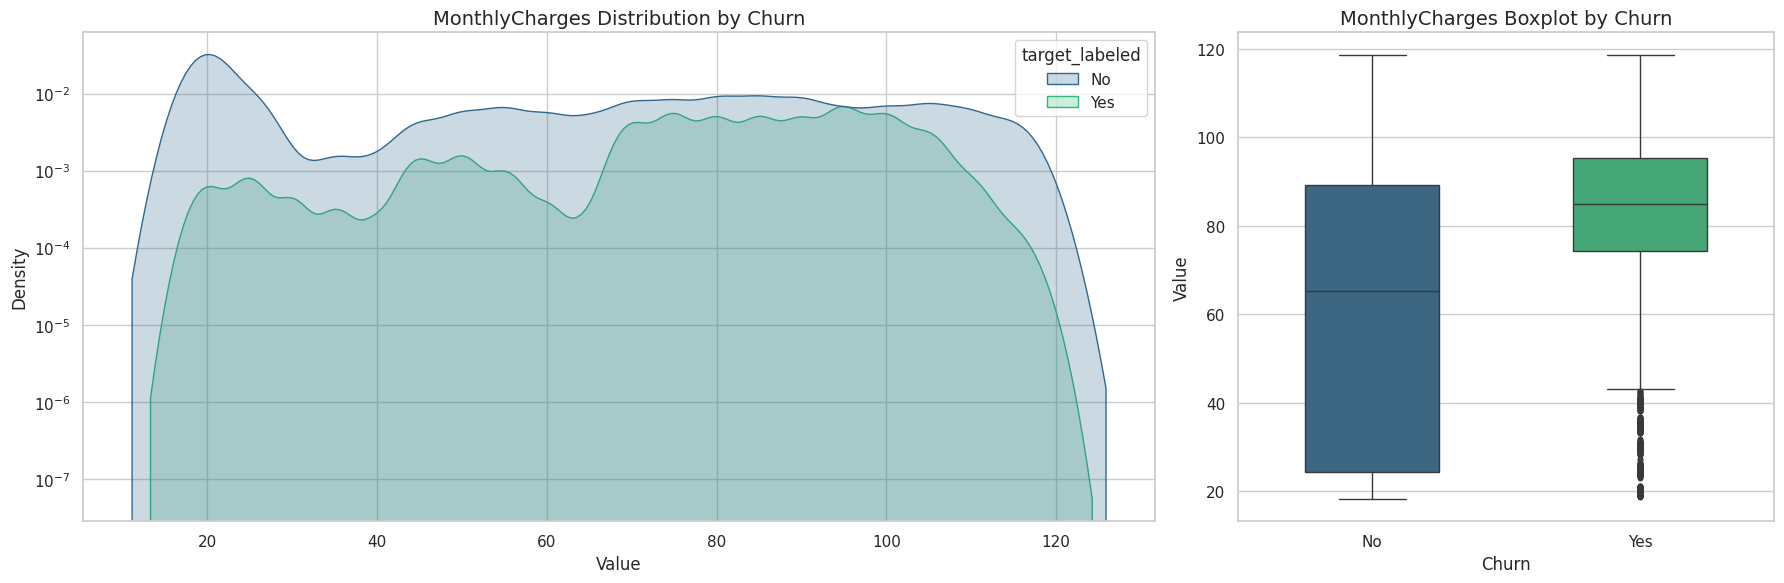


📌 TotalCharges Summary Statistics by Churn:


,mean,median,std
target_numerical,,,
0.0,2771.500515,1688.75,2423.054655
1.0,1540.976020,829.55,1797.643905


/tmp/ipython-input-10867/2692165875.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


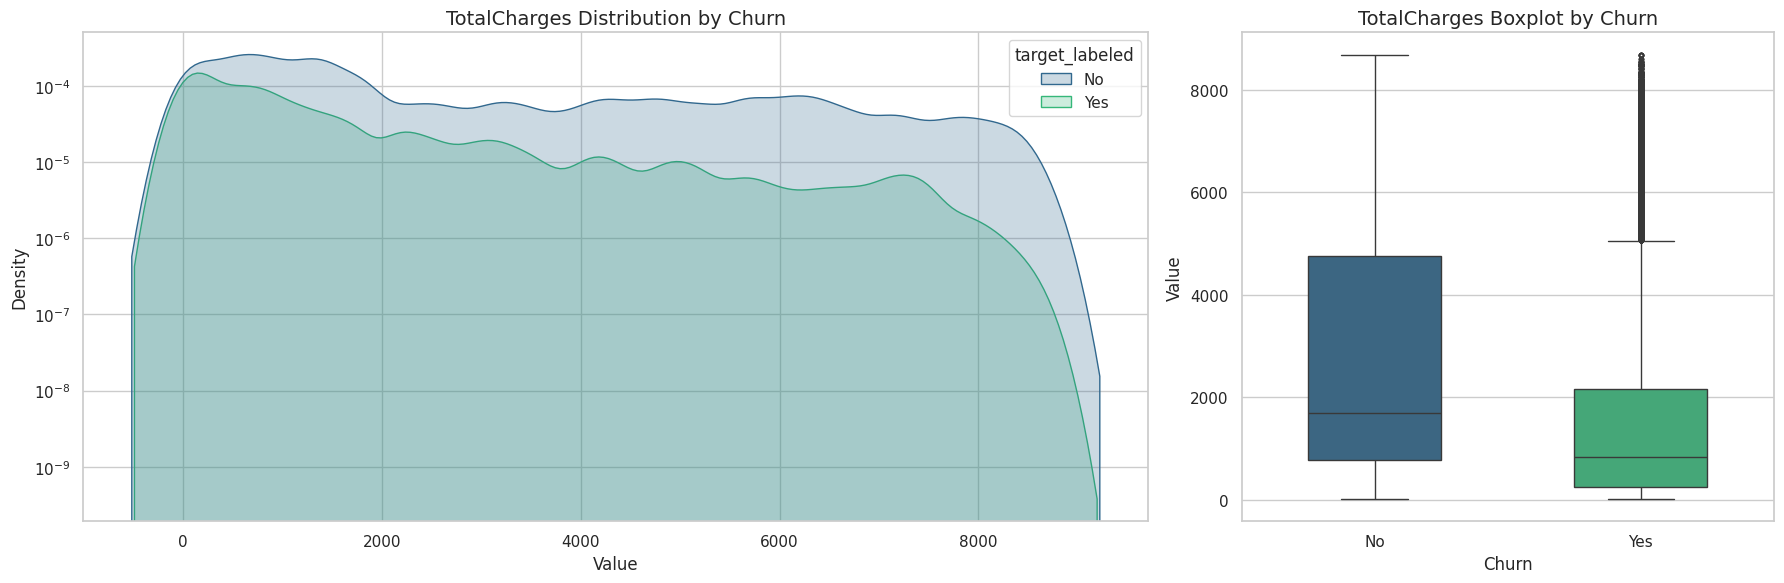

In [13]:
def plot_numerical_distributions(df, numerical_cols, target_col):

    sns.set_context("notebook")

    df_temp = df.copy()

    if df_temp[target_col].dtype == 'object':
        # Map 'Yes' to 1 and 'No' to 0 for numerical conversion of the 'Churn' target
        df_temp['target_numerical'] = df_temp[target_col].map({'Yes': 1, 'No': 0}).astype(float)
        df_temp['target_labeled'] = df_temp[target_col]
    else:
        df_temp['target_numerical'] = df_temp[target_col].astype(float)
        # Map 0 to 'No' and 1 to 'Yes' for labeling if target is already numerical
        df_temp['target_labeled'] = df_temp[target_col].map({0: 'No', 1: 'Yes'}).astype(str)


    if 'my_palette' not in locals() and 'my_palette' not in globals():
        my_palette = sns.color_palette("viridis", 2)

    # Use 'No' and 'Yes' for the palette labels
    current_palette = {'No': my_palette[0], 'Yes': my_palette[1]}

    for col in numerical_cols:
        print(f"\n📌 {col} Summary Statistics by {target_col}:")
        display(df_temp.groupby('target_numerical')[col].agg(['mean', 'median', 'std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        sns.kdeplot(
            data=df_temp, x=col, hue='target_labeled', ax=axes[0], fill=True, palette=current_palette
        )
        axes[0].set_title(f'{col} Distribution by {target_col}', fontsize=14)
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Density')
        if (df_temp[col] > 0).any():
            axes[0].set_yscale('log')

        sns.boxplot(
            data=df_temp, y=col, x='target_labeled', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette=current_palette
        )
        axes[1].set_title(f'{col} Boxplot by {target_col}', fontsize=14)
        axes[1].set_xlabel(target_col)
        axes[1].set_ylabel('Value')

        plt.tight_layout()
        plt.show()

# Call the function with the correct TARGET variable
plot_numerical_distributions(df_train, numerical_features, TARGET)

----
---
---

In [14]:
from typing import List, Tuple, Dict
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

def frequency_encode(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:

    df_freq = pd.DataFrame(index=df.index)
    for col in columns:
        if col in df.columns: # Check if column exists
            freqs = df[col].value_counts(normalize=True).to_dict()
            df_freq[f'{col}_freq'] = df[col].map(freqs).fillna(0)
    return df_freq

def engineer_features(
    X: pd.DataFrame,
    y: pd.Series,
    X_test: pd.DataFrame,
    num_columns: List[str],
    cat_columns: List[str],
    folds: int,
    seed: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """Engineers a variety of features for training and test data for Customer Churn Prediction."""
    print("Starting feature engineering...")

    X_current = X.copy()
    X_test_current = X_test.copy()
    # --- Initialize processed dataframes. These will contain ALL engineered features. ---
    X_train_final = pd.DataFrame(index=X.index)
    X_test_final_processed = pd.DataFrame(index=X_test.index)
    catboost_categorical_features = []

    # --- 1. Frequency Encoding (Global) ---
    print("  Applying Frequency Encoding...")
    # Apply frequency encoding to both numerical and categorical columns
    X_train_final = pd.concat([X_train_final, frequency_encode(X_current, num_columns + cat_columns)], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, frequency_encode(X_test_current, num_columns + cat_columns)], axis=1)

    # --- 2. Target Encoding (Out-of-Fold for main training data) ---
    print("  Applying Target Encoding...")
    X_target_encoded = pd.DataFrame(index=X.index)
    X_test_target_encoded = pd.DataFrame(index=X_test.index)

    # Ensure y is numeric for target encoding mean calculation
    y_numeric = y.map({'Yes': 1, 'No': 0}).astype(float) if y.dtype == 'object' else y.astype(float)
    global_mean = y_numeric.mean()

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_numeric)): # Use y_numeric for splitting
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr = y_numeric.iloc[train_idx]

        target_stats_map = {}
        for col in cat_columns + num_columns: # Target encode both cat and num
            if col in X_tr.columns:
                target_stats_map[col] = y_tr.groupby(X_tr[col]).mean().to_dict()

        for col in cat_columns + num_columns:
            if col in X_val.columns:
                X_target_encoded.loc[val_idx, f'{col}_target'] = X_val[col].map(target_stats_map.get(col, {})).fillna(global_mean)
            else: # If column not in X_val, use global mean
                X_target_encoded.loc[val_idx, f'{col}_target'] = global_mean

    full_target_stats_map = {}
    for col in cat_columns + num_columns:
        if col in X.columns:
            full_target_stats_map[col] = y_numeric.groupby(X[col]).mean().to_dict()

    for col in cat_columns + num_columns:
        if col in X_test.columns:
            X_test_target_encoded[f'{col}_target'] = X_test[col].map(full_target_stats_map.get(col, {})).fillna(global_mean)
        else: # If column not in X_test, use global mean
            X_test_target_encoded[f'{col}_target'] = global_mean

    X_train_final = pd.concat([X_train_final, X_target_encoded], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_target_encoded], axis=1)


    # --- 3. RobustScaler (for numerical columns) ---
    print("  Applying RobustScaler...")
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_current[num_columns]),
        columns=[f'{c}_scaled' for c in num_columns],
        index=X.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_current[num_columns]),
        columns=[f'{c}_scaled' for c in num_columns],
        index=X_test.index
    )
    X_train_final = pd.concat([X_train_final, X_scaled], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_scaled], axis=1)

    # --- 4. KBinsDiscretizer (for numerical columns) ---
    print("  Applying KBinsDiscretizer...")
    binner = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal', random_state=seed)
    X_binned = pd.DataFrame(
        binner.fit_transform(X_current[num_columns]),
        columns=[f'{c}_bin' for c in num_columns],
        index=X.index
    ).astype(int)
    X_test_binned = pd.DataFrame(
        binner.transform(X_test_current[num_columns]),
        columns=[f'{c}_bin' for c in num_columns],
        index=X_test.index
    ).astype(int)
    X_train_final = pd.concat([X_train_final, X_binned], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_binned], axis=1)
    catboost_categorical_features.extend([col for col in X_binned.columns])

    # --- 5. OrdinalEncoder (for categorical columns) ---
    print("  Applying OrdinalEncoder...")
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_ordinal = pd.DataFrame(
        encoder.fit_transform(X_current[cat_columns]),
        columns=[f'{c}_ordinal' for c in cat_columns],
        index=X.index
    ).astype(int)
    X_test_ordinal = pd.DataFrame(
        encoder.transform(X_test_current[cat_columns]),
        columns=[f'{c}_ordinal' for c in cat_columns],
        index=X_test.index
    ).astype(int)
    X_train_final = pd.concat([X_train_final, X_ordinal], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_ordinal], axis=1)
    catboost_categorical_features.extend([col for col in X_ordinal.columns])

    # --- 6: Interaction Features (Updated for Churn dataset) ---
    print("  Generating Interaction Features...")
    epsilon = 1e-6 # To prevent division by zero

    # Interaction between tenure and MonthlyCharges
    X_current['tenure_MonthlyCharges_interaction'] = X_current['tenure'] * X_current['MonthlyCharges']
    X_test_current['tenure_MonthlyCharges_interaction'] = X_test_current['tenure'] * X_test_current['MonthlyCharges']

    # Interaction between SeniorCitizen and MonthlyCharges
    X_current['SeniorCitizen_MonthlyCharges_interaction'] = X_current['SeniorCitizen'] * X_current['MonthlyCharges']
    X_test_current['SeniorCitizen_MonthlyCharges_interaction'] = X_test_current['SeniorCitizen'] * X_test_current['MonthlyCharges']

    interaction_cols = [
        'tenure_MonthlyCharges_interaction',
        'SeniorCitizen_MonthlyCharges_interaction'
    ]

    X_train_final = pd.concat([X_train_final, X_current[interaction_cols]], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_current[interaction_cols]], axis=1)

    # --- 7: Polynomial Features (Updated for Churn dataset) ---
    print("  Generating Polynomial Features...")
    poly_features_to_transform = ['tenure', 'MonthlyCharges', 'TotalCharges']
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

    X_poly_train = pd.DataFrame(
        poly.fit_transform(X_current[poly_features_to_transform]),
        columns=poly.get_feature_names_out(poly_features_to_transform),
        index=X.index
    )
    X_poly_test = pd.DataFrame(
        poly.transform(X_test_current[poly_features_to_transform]),
        columns=poly.get_feature_names_out(poly_features_to_transform),
        index=X_test.index
    )
    X_train_final = pd.concat([X_train_final, X_poly_train], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_poly_test], axis=1)

    # --- 8: Ratio Features (Updated for Churn dataset) ---
    print("  Generating Ratio Features...")
    # Ratio of TotalCharges to tenure (monthly average charge)
    # Handle cases where tenure might be 0, which would result in inf or NaN. Minimum tenure is 1.
    # Using replace(0, np.nan) for explicit handling, then fillna with epsilon.
    X_current['TotalCharges_per_tenure'] = X_current['TotalCharges'] / (X_current['tenure'].replace(0, np.nan).fillna(epsilon) + epsilon)
    X_test_current['TotalCharges_per_tenure'] = X_test_current['TotalCharges'] / (X_test_current['tenure'].replace(0, np.nan).fillna(epsilon) + epsilon)

    X_train_final = pd.concat([X_train_final, X_current[['TotalCharges_per_tenure']]], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_current[['TotalCharges_per_tenure']]], axis=1)

    # --- 9: Aggregate Features (Updated for Churn dataset) ---
    print("  Generating Aggregate Features...")
    group_cols = ['Contract', 'InternetService', 'PaymentMethod']
    agg_num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    for group_col in group_cols:
        if group_col in X_current.columns:
            for col in agg_num_cols:
                if col in X_current.columns:
                    # Calculate aggregates on X_current
                    grouped_mean = X_current.groupby(group_col)[col].transform('mean')
                    grouped_median = X_current.groupby(group_col)[col].transform('median')
                    grouped_std = X_current.groupby(group_col)[col].transform('std').fillna(0)

                    X_current[f'{col}_by_{group_col}_mean'] = grouped_mean
                    X_current[f'{col}_by_{group_col}_median'] = grouped_median
                    X_current[f'{col}_by_{group_col}_std'] = grouped_std

                    # Create mapping from X_current for X_test_current
                    agg_mapping_mean = X_current.groupby(group_col)[col].mean().to_dict()
                    agg_mapping_median = X_current.groupby(group_col)[col].median().to_dict()
                    agg_mapping_std = X_current.groupby(group_col)[col].std().fillna(0).to_dict()

                    # Apply mapping to X_test_current, filling NaNs for unseen categories
                    X_test_current[f'{col}_by_{group_col}_mean'] = X_test_current[group_col].map(agg_mapping_mean).fillna(grouped_mean.mean())
                    X_test_current[f'{col}_by_{group_col}_median'] = X_test_current[group_col].map(agg_mapping_median).fillna(grouped_median.median())
                    X_test_current[f'{col}_by_{group_col}_std'] = X_test_current[group_col].map(agg_mapping_std).fillna(grouped_std.mean())

    # Collect all newly created aggregate features
    agg_features_to_add = [col for col in X_current.columns if any(f'_by_{gc}_' in col for gc in group_cols) and col not in X.columns] # Ensure we only add newly created aggregate features
    X_train_final = pd.concat([X_train_final, X_current[agg_features_to_add]], axis=1)
    X_test_final_processed = pd.concat([X_test_final_processed, X_test_current[agg_features_to_add]], axis=1)

    print(f"Features engineered. Original: {X.shape[1]}, Processed: {X_train_final.shape[1]}")

    # Convert specific features to 'category' dtype for models like CatBoost
    for col in catboost_categorical_features:
        if col in X_train_final.columns:
            X_train_final[col] = X_train_final[col].astype(str).astype('category')
        if col in X_test_final_processed.columns:
            X_test_final_processed[col] = X_test_final_processed[col].astype(str).astype('category')
    print("Categorical features prepared for tree-based models (e.g., CatBoost) if applicable.")

    print("feature_engineering function updated and defined.")
    return X_train_final, X_test_final_processed, catboost_categorical_features

In [15]:
import torch
from catboost import CatBoostClassifier
from typing import List, Tuple, Dict, Any
import numpy as np

def train_ensemble_model(
    X_train_processed: pd.DataFrame,
    y_raw: pd.Series,
    X_test_final_processed: pd.DataFrame,
    catboost_categorical_features: List[str],
    FOLDS: int,
    SEEDS: List[int],
    active_model: str,
    model_specific_params: Dict[str, Any]
) -> Tuple[List[Any], np.ndarray, np.ndarray]:


    print(f"\nStarting {active_model} ensemble training...")

    trained_models = []
    all_oof_predictions_per_seed = []
    all_test_predictions_per_seed = []

    for seed_idx, seed in enumerate(SEEDS):
        print(f"\n  Training with Seed {seed}:")
        skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

        oof_preds_for_this_seed = np.zeros(len(X_train_processed))
        test_preds_for_this_seed_accumulated = np.zeros(len(X_test_final_processed))
        fold_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_processed, y_raw), 1):
            X_tr, X_val = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
            y_tr, y_val = y_raw.iloc[train_idx], y_raw.iloc[val_idx]

            model = None
            if active_model == 'CatBoost':
                current_model_params = model_specific_params.copy()
                current_model_params['random_seed'] = seed # Ensure reproducibility for each model
                current_model_params['cat_features'] = catboost_categorical_features

                model = CatBoostClassifier(**current_model_params)
                print(f"    Fold {fold} (Seed {seed}): CatBoost fitting...")
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=model_specific_params.get('early_stopping_rounds', 100), verbose=False)

            elif active_model == 'RealMLP':
                mlp_params = model_specific_params.copy()
                mlp_params['random_state'] = seed
                mlp_params.pop('verbosity', None) # Remove if exists

                model = RealMLP_TD_Classifier(**mlp_params)
                print(f"    Fold {fold} (Seed {seed}): RealMLP fitting...")
                model.fit(X_tr.values, y_tr.values, X_val.values, y_val.values)
            else:
                raise ValueError(f"Unsupported model type: {active_model}")

            trained_models.append(model)

            # For CatBoost, X_val is already handled as DataFrame; for RealMLP, it expects numpy array.
            # The predict_proba for CatBoost can handle DataFrame, but RealMLP needs numpy. Let's ensure consistency if possible, or handle explicitly.
            # For RealMLP, predict_proba expects numpy array
            if active_model == 'RealMLP':
                val_pred_proba = model.predict_proba(X_val.values)[:, 1]
            else:
                val_pred_proba = model.predict_proba(X_val)[:, 1]
            oof_preds_for_this_seed[val_idx] = val_pred_proba

            # For RealMLP, predict_proba expects numpy array
            if active_model == 'RealMLP':
                test_pred_proba = model.predict_proba(X_test_final_processed.values)[:, 1]
            else:
                test_pred_proba = model.predict_proba(X_test_final_processed)[:, 1]
            test_preds_for_this_seed_accumulated += test_pred_proba / FOLDS # Accumulate, divided by number of folds

            score = roc_auc_score(y_val, val_pred_proba)
            fold_scores.append(score)
            print(f"    Fold {fold} (Seed {seed}): Val AUC = {score:.5f}")

            if 'torch' in globals() and torch.cuda.is_available():
                torch.cuda.empty_cache()

        total_oof_score_this_seed = roc_auc_score(y_raw, oof_preds_for_this_seed)
        mean_fold_score_this_seed = np.mean(fold_scores)
        print(f"  Seed {seed} OOF ROC-AUC: {total_oof_score_this_seed:.5f}")
        print(f"  Seed {seed} Mean Fold Score: {mean_fold_score_this_seed:.5f} (+/- {np.std(fold_scores):.5f})")

        all_oof_predictions_per_seed.append(oof_preds_for_this_seed)
        all_test_predictions_per_seed.append(test_preds_for_this_seed_accumulated)


    # Final average across all seeds for this model type
    final_oof_train_predictions = np.mean(all_oof_predictions_per_seed, axis=0)
    final_all_test_predictions = np.mean(all_test_predictions_per_seed, axis=0)

    print(f"\nSuccessfully trained {len(trained_models)} {active_model} models across {len(SEEDS)} seeds and {FOLDS} folds.")
    return trained_models, final_all_test_predictions, final_oof_train_predictions

print("model_trainer functions defined.")

model_trainer functions defined.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

def calculate_metrics(y_true: np.ndarray, y_proba: np.ndarray, y_pred: np.ndarray) -> tuple:
    print("\nCalculating performance metrics...")
    roc_auc = roc_auc_score(y_true, y_proba)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"   - ROC AUC Score: {roc_auc:.4f}")
    print(f"   - Accuracy Score: {accuracy:.4f}")
    print(f"   - F1-Score: {f1:.4f}")
    print(f"   - Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    return roc_auc, accuracy, f1, mcc

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str = 'Confusion Matrix') -> None:
    print(f"\nGenerating {title}...")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='viridis', ax=ax)
    ax.set_title(title, fontsize=14)
    plt.show()
    print("Confusion matrix displayed.")

def plot_roc_curve(y_true: np.ndarray, y_proba: np.ndarray, roc_auc: float, title: str = 'Receiver Operating Characteristic (ROC) Curve') -> None:
    print(f"\nGenerating {title} for the ensemble model...")
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print("ROC Curve generated and displayed.")

def plot_feature_importances(trained_models: list, X_train_processed: pd.DataFrame, N_TOP_FEATURES: int = 20) -> None:
    print("\nVisualizing Feature Importances...")

    if not trained_models:
        print("No trained models available to visualize feature importances.")
        return

    # Aggregate feature importances from all models that support it
    all_feature_importances = []
    feature_names = X_train_processed.columns.tolist()

    for model in trained_models:
        if isinstance(model, CatBoostClassifier):
            all_feature_importances.append(model.get_feature_importance()) # Feature importance for CatBoost
        elif hasattr(model, 'feature_importances_'): # For other models like LightGBM, XGBoost
            all_feature_importances.append(model.feature_importances_)
        elif isinstance(model, RealMLP_TD_Classifier):
            print(f"  Skipping feature importance for {type(model).__name__}: direct feature importance not available.")
        else:
            print(f"  Skipping feature importance for unknown model type: {type(model).__name__}.")

    if not all_feature_importances:
        print("No valid feature importances could be extracted from the models.")
        return

    # Average feature importances across models
    avg_feature_importances = np.mean(all_feature_importances, axis=0)

    df_feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_feature_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=df_feature_importances.head(N_TOP_FEATURES), palette='viridis')
    plt.title(f'Top {N_TOP_FEATURES} Feature Importances from Ensemble Models', fontsize=16)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("Feature importances visualization complete.")

print("evaluation_utils functions defined.")

evaluation_utils functions defined.


In [17]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Any

def generate_submission(test_preds: List[np.ndarray], test_ids: np.ndarray, output_filename: str = 'submission.csv') -> None:

    print("Generating final ensemble predictions and submission file...")

    final_pred = test_preds[0]

    submission_df = pd.DataFrame({
        'id': test_ids,
        TARGET: final_pred
    })

    submission_df.to_csv(output_filename, index=False)

    print(f"\n✓ Submission file '{output_filename}' created successfully.")
    print("   First 5 rows of the submission file:")
    # Using display here because it's in a notebook context
    try:
        from IPython.display import display
        display(submission_df.head())
    except ImportError:
        print(submission_df.head())

print("submission_generator function defined.")

submission_generator function defined.


In [18]:
from sklearn.linear_model import LogisticRegression



print("\n" + "="*80)
print("Beginning Customer Churn Prediction Workflow")
print("="*80)

X_raw, y_raw, test_ids, X_test_raw = load_and_prepare_initial_data(
    TRAIN_PATH, TEST_PATH,
    target_column=TARGET, # Use the global TARGET variable
    target_map=CHURN_MAP # Use the global CHURN_MAP
)

X_train_engineered, X_test_engineered, catboost_categorical_features = engineer_features(
    X_raw, y_raw, X_test_raw,
    NUM_COLUMNS, CAT_COLUMNS,
    FOLDS, SEED
)

print(f"Length of X_test_engineered after feature engineering: {len(X_test_engineered)}")
# -----------------------------------------------------

trained_models: List[Any] = []
all_test_predictions: np.ndarray = np.array([])
oof_train_predictions: np.ndarray = np.zeros(len(X_train_engineered))

if ACTIVE_MODEL == 'CatBoost':
    print("\n" + "="*80)
    print(f"Training a single {ACTIVE_MODEL} model.")
    print("="*80)
    current_model_params = CATBOOST_PARAMS
    trained_models, all_test_predictions, oof_train_predictions = train_ensemble_model(
        X_train_engineered, y_raw, X_test_engineered,
        catboost_categorical_features, FOLDS, SEEDS,
        ACTIVE_MODEL, current_model_params
    )
elif ACTIVE_MODEL == 'RealMLP':
    print("\n" + "="*80)
    print(f"Training a single {ACTIVE_MODEL} model.")
    print("="*80)
    current_model_params = REALMLP_TD_PARAMS
    trained_models, all_test_predictions, oof_train_predictions = train_ensemble_model(
        X_train_engineered, y_raw, X_test_engineered,
        catboost_categorical_features, FOLDS, SEEDS,
        ACTIVE_MODEL, current_model_params
    )
elif ACTIVE_MODEL == 'Ensemble':
    print("\n" + "="*80)
    print("Training an Ensemble model (CatBoost + RealMLP).")
    print("="*80)

    # Train CatBoost
    print("\n" + "---"*20)
    print("Training CatBoost models for Ensemble...")
    print("---"*20)
    cb_trained_models, cb_test_preds, cb_oof_preds = train_ensemble_model(
        X_train_engineered, y_raw, X_test_engineered,
        catboost_categorical_features, FOLDS, SEEDS,
        'CatBoost', CATBOOST_PARAMS
    )

    print("\n" + "---"*20)
    print("Training RealMLP models for Ensemble...")
    print("---"*20)
    mlp_trained_models, mlp_test_preds, mlp_oof_preds = train_ensemble_model(
        X_train_engineered, y_raw, X_test_engineered,
        catboost_categorical_features, FOLDS, SEEDS,
        'RealMLP', REALMLP_TD_PARAMS
    )

    trained_models = cb_trained_models + mlp_trained_models

    print("\n" + "---"*20)
    print("Implementing Stacking/Blending with Meta-Model...")
    print("---"*20)

    X_meta_train = pd.DataFrame({
        'cb_oof_preds': cb_oof_preds,
        'mlp_oof_preds': mlp_oof_preds
    })

    X_meta_test = pd.DataFrame({
        'cb_oof_preds': cb_test_preds,
        'mlp_oof_preds': mlp_test_preds
    })

    # 3. Instantiate a LogisticRegression model for the meta-model
    meta_model = LogisticRegression(solver='liblinear', random_state=SEED)
    print("  Training Meta-Model (LogisticRegression)...")

    # 4. Train the meta-model
    meta_model.fit(X_meta_train, y_raw)

    # 5. Use the trained meta-model to predict probabilities on X_meta_test
    final_all_test_predictions = meta_model.predict_proba(X_meta_test)[:, 1]
    print("  Meta-Model predictions generated for test set.")

    # 6. Use the trained meta-model to predict probabilities on X_meta_train
    oof_train_predictions = meta_model.predict_proba(X_meta_train)[:, 1]
    print("  Meta-Model OOF predictions generated for training set.")

    all_test_predictions = final_all_test_predictions
    # ------------------------------------------------------------------------------------------

else:
    raise ValueError(f"Unsupported ACTIVE_MODEL: {ACTIVE_MODEL}. Must be 'CatBoost', 'RealMLP', or 'Ensemble'.")

print(f"Length of all_test_predictions after model training: {len(all_test_predictions)}")
# ------------------------------------------------------

y_proba_ensemble_train = oof_train_predictions
y_pred_ensemble_train = (y_proba_ensemble_train >= 0.5).astype(int)


Beginning Customer Churn Prediction Workflow
Preparing initial data (using specified paths and target mapping)...
Encoding 'Churn' target variable...
Initial data prepared. X shape: (594194, 19), y shape: (594194,), X_test shape: (254655, 19)
Starting feature engineering...
  Applying Frequency Encoding...
  Applying Target Encoding...
  Applying RobustScaler...
  Applying KBinsDiscretizer...
  Applying OrdinalEncoder...
  Generating Interaction Features...
  Generating Polynomial Features...
  Generating Ratio Features...
  Generating Aggregate Features...
Features engineered. Original: 19, Processed: 100
Categorical features prepared for tree-based models (e.g., CatBoost) if applicable.
feature_engineering function updated and defined.
Length of X_test_engineered after feature engineering: 254655

Training an Ensemble model (CatBoost + RealMLP).

------------------------------------------------------------
Training CatBoost models for Ensemble...
------------------------------------

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print("\n" + "="*80)
print("Optimizing Prediction Threshold")
print("="*80)

# Define a range of possible thresholds
thresholds = np.arange(0.05, 0.96, 0.01)

best_mcc_score = -1
optimal_threshold = 0.5

for thresh in tqdm(thresholds, desc="Optimizing threshold"):
    y_pred_current = (y_proba_ensemble_train >= thresh).astype(int)

    current_mcc = matthews_corrcoef(y_raw, y_pred_current)

    if current_mcc > best_mcc_score:
        best_mcc_score = current_mcc
        optimal_threshold = thresh

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"Best MCC Score at optimal threshold: {best_mcc_score:.4f}")

y_pred_ensemble_train = (y_proba_ensemble_train >= optimal_threshold).astype(int)

print("Prediction threshold optimization complete.")

In [ ]:
print("\n" + "="*80)
print("Analyzing Class Distribution in Training Data")
print("="*80)

class_counts = y_raw.value_counts()
print("\nClass Counts:")
print(class_counts)

class_proportions = y_raw.value_counts(normalize=True)
print("\nClass Proportions:")
print(class_proportions)

print("\nClass distribution analysis complete.")

plt.figure(figsize=(7, 5))
sns.barplot(x=class_proportions.index, y=class_proportions.values, palette='viridis')
plt.title('Class Distribution in Training Data', fontsize=14)
plt.xlabel('Churn (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Class distribution visualization complete.")

In [ ]:
print("\n" + "="*80)
print("Evaluating Class-Specific Metrics and Impact of Class Weights")
print("="*80)

# 1. Print a classification report
print("\nClassification Report (OOF Predictions with Optimal Threshold):\n")
print(classification_report(y_raw, y_pred_ensemble_train, target_names=['No (0)', 'Yes (1)']))


print("Class-specific metric evaluation complete.")

In [ ]:
print("\n" + "="*80)
print(f"Evaluating {ACTIVE_MODEL} Model Performance on Training Data (OOF Predictions)")
print("="*80)

roc_auc, accuracy, f1, mcc = calculate_metrics(
    y_raw, y_proba_ensemble_train, y_pred_ensemble_train
)

print(f"\n\ud83d\udcca **{ACTIVE_MODEL} Model Performance on Training Data (OOF)**")
print(f"   - ROC AUC Score: {roc_auc:.4f}")
print(f"   - Accuracy Score: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# 5. Visualize Results
plot_confusion_matrix(y_raw, y_pred_ensemble_train, title=f'Confusion Matrix for {ACTIVE_MODEL} Model (OOF Training Data)')
plot_roc_curve(y_raw, y_proba_ensemble_train, roc_auc, title=f'Receiver Operating Characteristic (ROC) Curve for {ACTIVE_MODEL} Model (OOF)')

catboost_models_in_ensemble = [m for m in trained_models if isinstance(m, CatBoostClassifier)]

if catboost_models_in_ensemble:
    print(f"\nAttempting to visualize feature importances for CatBoost models within the {ACTIVE_MODEL} ensemble.")
    plot_feature_importances(catboost_models_in_ensemble, X_train_engineered, N_TOP_FEATURES=20)
else:
    print(f"\nSkipping Feature Importances visualization: No CatBoost models found in the {ACTIVE_MODEL} ensemble, or not applicable for other model types like RealMLP.")

In [ ]:
final_test_predictions_for_submission = all_test_predictions

print("\n" + "✨"*10 + " FINAL RESULTS " + "✨"*10)
print("="*80)

print(f"\n📊 **Ensemble Model Performance on Training Data**")
print(f"   - ROC AUC Score: {roc_auc:.4f}")
print(f"   - Accuracy Score: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Matthews Correlation Coefficient (MCC): {mcc:.4f}")

print("\n" + "="*80)

# --- Diagnostic prints for length mismatch ---
print(f"Length of test_ids: {len(test_ids)}")
print(f"Length of final_test_predictions_for_submission: {len(final_test_predictions_for_submission)}")
# ----------------------------------------------

generate_submission(
    [final_test_predictions_for_submission], test_ids,
    output_filename=f'submission.csv'
)

print("\n" + "="*80)
print("✨ MODELING PIPELINE COMPLETE! ✨")
print("="*80)

----
----
---